# Plot Figures 5 (PCA), 6 (waveforms), boxplots for stats, rep fingerprints and sgrams, 12 (reconstruct)


These figures show clustering metrics and PCA

For Sawi et al., 2021


#### Todo:

* I should put PCA and clusteirng in a separate notebook .... 

* XShow 2D PCA
* PCA by timelines, stats
* Combine PCA and SS / Elbo
* Combine waveform and spectra


* XSimple Reconstruc workflow example
* Xexample waveforms --> clustered waveforms
* Xsplit up waveforms and spectra 
* Xspectra -> ACM -> STM for IQ and NS ?

## Todo::


* Why is cluster assignment changing in k-means even when I set random state to 0? Try 42??

In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
# sys.path.insert(0, '../01_DataPrep')
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max

import math

sys.path.append('.')
sys.path.append('./functions/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [2]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram,catMergeFromH5,lagWF,calcCorr_template
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat, calcCorr_template, calcCCMatrix

from functions2 import getSpectra,getFP,getMaxIndexFP,calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF, lagWF,getFeatures_Explore
import figureFunctions2
from functions2 import getFeatures_Explore


## Set paths

In [3]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Redo_v2"
# keyN = "BB_Gorner_Cont_Final_v10_J8"
keyN = "BB_Gorner_Cont_Redo_v5"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN

pathFig = '../05_reports/figures/'
pathFigSupp = '../05_reports/supp_figures/'
pathAuxData = '../01_input/data/processed/Garcia/'

## Load auxiliary catalog

In [4]:
pathAuxData

'../01_input/data/processed/Garcia/'

In [5]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')

rain_df = meteor_df.rain

## Define some important times in study period

In [6]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [7]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)

cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)

1457 events kept, merge sucessful
1472 events kept, merge sucessful


In [8]:
cat00['event_ID']

datetime_index
2007-06-14 09:30:58    70614093058
2007-06-14 11:31:25    70614113125
2007-06-14 12:03:56    70614120356
2007-06-14 12:07:17    70614120717
2007-06-14 12:10:58    70614121058
                          ...     
2007-07-21 16:56:23    70721165623
2007-07-21 17:11:34    70721171134
2007-07-21 17:15:16    70721171516
2007-07-21 19:21:46    70721192146
2007-07-21 19:35:14    70721193514
Name: event_ID, Length: 1457, dtype: object

## Load station data

In [9]:
##station data 
stn = pd.read_csv("../01_input/data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [10]:
len(cat00),len(cat00N)
# BB_Gorner_Event_Final_v11_J8
# BB_Gorner_Cont_Final_v10_J8

(1457, 1472)

In [11]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
#     fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
#     tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
with h5py.File(path_proj + outfile_name,mode='a') as sub_catalog_h5:
    fSTFT = sub_catalog_h5['spec_parameters/'].get('fSTFT')[()]
    tSTFT = sub_catalog_h5['spec_parameters/'].get('tSTFT')[()] 
    
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [12]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [13]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
#all times in UTC
hour_of_approx_max_temp = 14
hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [14]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend     ## actual study bound
             }

## Specs for figures JGR

In [15]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Figure 5 - Reduce dimensionality, visualize PC plots by time, hour

* Perform PCA on FPs 
* Calculate PVE (percent variance explained) for each PC, and keep enouch PCs to capture XX% of variance



In [16]:

PCA_df, numPCA_PVE, cum_pve = PVEofPCA(path_proj,outfile_name,cat00,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False);
PCA_dfN, numPCA_PVEN, cum_pveN = PVEofPCA(path_projN,outfile_nameN,cat00N,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False)



1 0.139611637133
2 0.222445441964
3 0.275782945965
4 0.310813464626
5 0.342300363597
6 0.36998208372
7 0.395178699474
8 0.417064259711
9 0.435528167762
10 0.453338451491
11 0.470195063297
12 0.486136300266
13 0.50133165718
14 0.515505317851
15 0.529005445136
16 0.541974733459
17 0.554621874734
18 0.567025952193
19 0.578607064139
20 0.589974753718
21 0.601094495117
22 0.611491767339
23 0.620982389685
24 0.630617147423
25 0.638862055956
26 0.648140277217
27 0.656328845844
28 0.664554234418
29 0.672574362265
30 0.680411378429
31 0.687814314883
32 0.695134269909
33 0.702255545018
34 0.708955142755
35 0.715840297937
36 0.721887249098
37 0.728434235095
38 0.734660857104
39 0.740956600271
40 0.746538819285
41 0.752307176731
42 0.757974735056
43 0.763643462134
44 0.768950850739
45 0.773880603531
46 0.779470557337
47 0.784451798006
48 0.789447528224
49 0.794273101534
50 0.798545549227
51 0.80322378435
52 0.80728963513
53 0.811767642775
54 0.815924825129
55 0.819982215197
56 0.823899345267
57 0.

In [17]:
print(f'\n For icequakes, {100*cum_pve:.2f}% of variance explained by the first {numPCA_PVE} principal components')
print(f'\n For noise, {100*cum_pveN:.2f}% of variance explained by the first {numPCA_PVEN} principal components')


 For icequakes, 86.24% of variance explained by the first 67 principal components

 For noise, 89.38% of variance explained by the first 3 principal components


In [18]:
stand = False #standard scalar before PCA


#returns a PCA sklearn object, a dataframe of cat00 but with columns for PCs, and a numpy array of PCs (N x numPC)

sklearn_pca, cat00, Y_PCA = PCAonFP(path_proj,outfile_name,cat00,numPCA=numPCA_PVE,stand=stand)
sklearn_pcaN, cat00N, Y_PCAN = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=numPCA_PVEN,stand=stand)


## PCA plot colored by datetime

In [19]:
## format arrays for plotting 

hour_list = [h.hour for h in cat00.datetime]
hour_listN = [h.hour for h in cat00N.datetime]

cat00['hod'] = hour_list
cat00N['hod'] = hour_listN


series_datetime = cat00.datetime
series_datetimeN = cat00N.datetime


series_hour = cat00.hod
series_hourN = cat00N.hod

datenum = [int(round(a.timestamp())) for a in cat00N.datetime]
cat00N['datenum'] = datenum


In [20]:
# cmaps = [plt.get_cmap('twilight_shifted'),
#          plt.get_cmap('rainbow')]#,




# df_stats = [np.array(cat00N.hod),
#             np.array(cat00N.datenum)]


# stat_names = ['Hour of day',
#              'Date, 2007']#,



# for dd,ss,cc in zip(df_stats,stat_names,cmaps):
    
#     fig = plt.figure(figsize=(20,20))

#     ax = fig.add_subplot(121, projection='3d')

#     figureFunctions2.plotPCA_Stat(cat00N, cat00N, dd, ss, Kopt=4,cmap=cc)


In [21]:

# ## where did cat datenum column go for noise catalog?


# cmaps = [plt.get_cmap('twilight_shifted'),
#          plt.get_cmap('rainbow'),
#          plt.get_cmap('rainbow')]



# df_stats = [np.array(cat00.hod),
#             np.array(cat00.datenum),
#             np.array(cat00.SS)]

# stat_names = ['Hour of day',
#              'Date, 2007',
#              'Silhouette score']


# for df_stat,stat_name,cmap in zip(df_stats,stat_names,cmaps):
    
#     fig = plt.figure(figsize=(20,20))

#     ax = fig.add_subplot(121, projection='3d')

#     figureFunctions2.plotPCA_Stat(cat00, catall, df_stat, stat_name, Kopt=Kopt,cmap=cmap)
    

# Figure 6 - clustering results [using mean silh score, not median -- outliers should influence clustering]

## Clustering using Kmeans, validating using silhouette score


#### do not run::

In [22]:
# ## silh score and validation
# ##making rep catalog


##can force K here
Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


cat00, catall, Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters_all,numPCA=numPCA_PVE,Xtype='fingerprints', distMeasure = "SilhScore",stand=stand);

print('Event optimum number of clusters:: ',Kopt)


cat00N, catallN, KoptN, maxSilScoreN, avgSilsN, sseN,cluster_labels_bestN,ss_bestN,euc_dist_bestN = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clusters_all,numPCA=numPCA_PVEN,Xtype='fingerprints',distMeasure = "SilhScore", stand=stand);


print('Noise optimum number of clusters:: ',KoptN)



kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 3
Event optimum number of clusters::  3
kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4
Noise optimum number of clusters::  4


### Swap labels to match manuscript colors

In [23]:
# # from functions2 import swapLabels
cat00 = swapLabels(cat00,1,3)
cat00N = swapLabels(cat00N,2,4)
cat00N = swapLabels(cat00N,1,2)
cat00N = swapLabels(cat00N,1,3)

## save new cluster catalogs

In [24]:
pwd

'/Users/theresasawi/Documents/SpecUFEx_v1/BB_Gorner_Event_Redo_v2/02_src'

In [25]:
# # #### overwrite catalogs!!

cat00.to_csv(f'../01_input/data/interim/{key}_icequakes_k{Kopt}.csv')
cat00N.to_csv(f'../01_input/data/interim/{keyN}_noise_k{KoptN}.csv')


np.save(f'../01_input/data/interim/maxSilScoreN.npy',maxSilScoreN)
np.save(f'../01_input/data/interim/avgSilsN.npy',avgSilsN)
np.save(f'../01_input/data/interim/sseN.npy',sseN)

np.save(f'../01_input/data/interim/maxSilScore.npy',maxSilScore)
np.save(f'../01_input/data/interim/avgSils.npy',avgSils)
np.save(f'../01_input/data/interim/sse.npy',sse)




In [26]:
ls ../01_input/data/interim/

BB_Gorner_Cont_Redo_noise_k4.csv
BB_Gorner_Cont_Redo_v2_ccLagMat_top20_SS_N.npy
BB_Gorner_Cont_Redo_v2_ccMat_top20_SS_N.npy
BB_Gorner_Cont_Redo_v2_df_statALLN.csv
BB_Gorner_Cont_Redo_v2_noise_k4.csv
BB_Gorner_Cont_Redo_v3_noise_k3.csv
BB_Gorner_Cont_Redo_v3_noise_k4.csv
BB_Gorner_Cont_Redo_v4_noise_k3.csv
BB_Gorner_Cont_Redo_v5_df_statALLN.csv
BB_Gorner_Cont_Redo_v5_noise_k4.csv
BB_Gorner_Cont_Redo_v6_df_statALLN.csv
BB_Gorner_Cont_Redo_v6_noise_k4.csv
BB_Gorner_Event_Redo_v2_ccLagMat_top20_SS.npy
BB_Gorner_Event_Redo_v2_ccLagMat_top30_SS.npy
BB_Gorner_Event_Redo_v2_ccMat_top20_SS.npy
BB_Gorner_Event_Redo_v2_ccMat_top30_SS.npy
BB_Gorner_Event_Redo_v2_df_locALL.csv
BB_Gorner_Event_Redo_v2_df_statALL.csv
BB_Gorner_Event_Redo_v2_df_statALLN.csv
BB_Gorner_Event_Redo_v2_icequakes_k3.csv
avgSils.npy
avgSilsN.npy
ccLagMat_top20_SS_N.npy
ccMat_top20_SS_N.npy
icequakes_k3.csv
maxSilScore.npy
maxSilScoreN.npy
noise_k4.csv
sse.npy
sseN.npy


In [178]:
Kopt = 3
KoptN = 4

## # # we prefer to read the catalogs originally created  .... 
cat00 = pd.read_csv(f'../01_input/data/interim/{key}_icequakes_k{Kopt}.csv')
cat00N = pd.read_csv(f'../01_input/data/interim/{keyN}_noise_k{KoptN}.csv')

cat00['event_ID'] = [int(evv) for evv in cat00.event_ID]
cat00N['event_ID'] = [int(evv) for evv in cat00N.event_ID]

#why two the same?? not sure : / 
cat00['evID'] = [int(evv) for evv in cat00.evID]



maxSilScoreN = np.load(f'../01_input/data/interim/maxSilScoreN.npy')
avgSilsN     = np.load(f'../01_input/data/interim/avgSilsN.npy')
sseN         = np.load(f'../01_input/data/interim/sseN.npy')

maxSilScore = np.load(f'../01_input/data/interim/maxSilScore.npy')
avgSils     = np.load(f'../01_input/data/interim/avgSils.npy')
sse         = np.load(f'../01_input/data/interim/sse.npy')


In [179]:
for k in range(1,Kopt+1):
    print(f'len cluster {k}:')
    print(len(cat00[cat00.Cluster==k]))

    
print('\n')
for k in range(1,KoptN+1):
    print(f'len cluster {k}:')
    print(len(cat00N[cat00N.Cluster==k]))

len cluster 1:
157
len cluster 2:
455
len cluster 3:
845


len cluster 1:
344
len cluster 2:
182
len cluster 3:
473
len cluster 4:
473


## Plot PCA with {topF} most representative events

In [28]:
topF = 30

catRep = getTopFCat(cat00,topF=topF)
catRep.event_ID = [int(c) for c in catRep.event_ID]
catRepN = getTopFCat(cat00N,topF=topF)
catRepN.event_ID = [int(c) for c in catRepN.event_ID]

In [29]:
catRepN.event_ID

datetime_index
2007-07-18 02:41:59    70718024159
2007-07-11 02:28:59    70711022859
2007-07-17 06:22:00    70717062200
2007-07-20 23:39:00    70720233900
2007-07-11 18:24:00    70711182400
                          ...     
2007-06-26 19:03:00    70626190300
2007-06-28 20:59:59    70628205959
2007-06-21 17:46:59    70621174659
2007-07-03 19:49:00    70703194900
2007-06-14 21:31:59    70614213159
Name: event_ID, Length: 120, dtype: int64

# Plot 5 -- PCA with cluster assignment and SS & Elbo plots

The red cluster has many identical fingerprints (n=555/601) with really high silh scores (>.92), and so they exaggerate the mean silhouette score for the noise clusters.

3 4


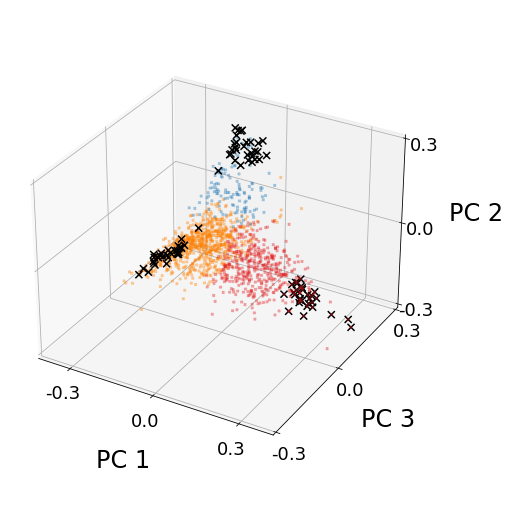

In [172]:
## Plot PCA by datetime, show rep events
tfont=14
plt.rcParams.update({'font.size': 18})


print(Kopt,KoptN)

fig,axes = plt.subplots(figsize = (width2,height2))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')


size_dot = 6
alpha_dot = .4
size_rep = 50

label_fontsize = fontsize = 24

atext = 25


#####IQ
## PLot PCA
# ax = fig.add_subplot(231, projection='3d')
ax = fig.add_subplot(111, projection='3d')
figureFunctions2.plotPCA(cat00,catRep,Kopt, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad = 25,fontsize=fontsize,ax=ax, fig=fig, **plt_kwargs)
ax.set_ylim(-.3,.3)
ax.set_xlim(-.4,.4)    
ax.set_zlim(-.3,.3)
# ax.set_title('c.',fontsize=atext,loc='left')

plt.savefig(pathFig + 'PCAIQ.png', dpi=300,bbox_inches='tight')





In [31]:

pathFig



'../05_reports/figures/'

3 4


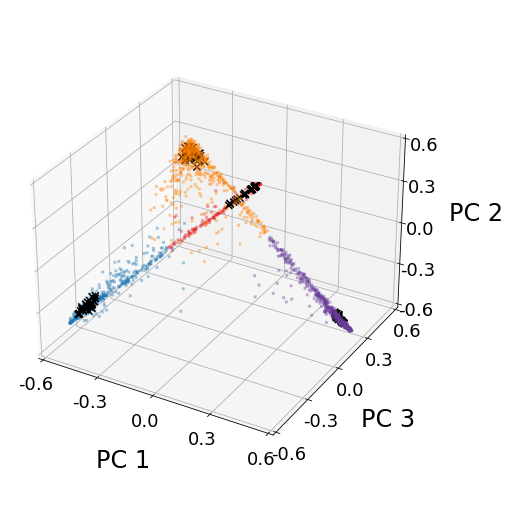

In [171]:
## Plot PCA by datetime, show rep events
tfont=14
plt.rcParams.update({'font.size': 18})


print(Kopt,KoptN)

fig,axes = plt.subplots(figsize = (width2,height2))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')


size_dot = 6
alpha_dot = .4
size_rep = 50

label_fontsize = fontsize = 24




#####NS
## PLot PCA
# ax = fig.add_subplot(231, projection='3d')
ax = fig.add_subplot(111, projection='3d')
figureFunctions2.plotPCA(cat00N,catRepN,KoptN, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad = 25,fontsize=fontsize,ax=ax, fig=fig, **plt_kwargs)
# ax.set_ylim(-.3,.3)
# ax.set_xlim(-.4,.4)    
# ax.set_zlim(-.3,.3)

plt.savefig(pathFig + 'PCANS.png', dpi=300,bbox_inches='tight')

3 4


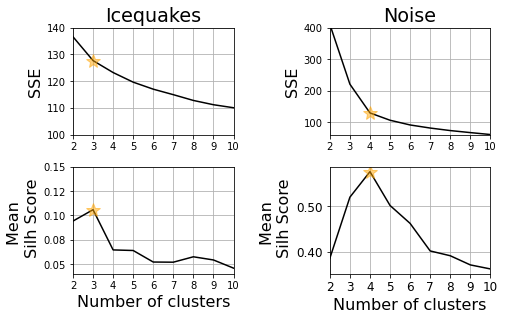

In [173]:
## Plot PCA by datetime, show rep events
from matplotlib.ticker import FormatStrFormatter

tfont=14
plt.rcParams.update({'font.size': 16})

Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


xlabelsize=10



print(Kopt,KoptN)


xlabelsize=10

fig,axes = plt.subplots(figsize = (width2,height1))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')




### Plot silh Scores
ax = fig.add_subplot(221)
figureFunctions2.plotSSE(Kopt, sse, range_n_clusters_all,starSize=15,ax=ax)
ax.set_title('Icequakes')
ax.set_ylabel('SSE')
ax.set_ylim(100,140)
ax.set_xlim(2,10)
ax.set_xlabel('')
# ax.set_xticklabels([])
ax.tick_params(axis='both', which='major', labelsize=10)



ax = fig.add_subplot(222)
figureFunctions2.plotSSE(KoptN, sseN, range_n_clusters_all,starSize=15,ax=ax)
ax.set_title('Noise')
ax.set_ylabel('SSE')
ax.set_ylim(60,400)
ax.set_xlim(2,10)
ax.set_xlabel('')
# ax.set_xticklabels([])
ax.tick_params(axis='both', which='major', labelsize=10)



### Plot silh Scores
ax = fig.add_subplot(223)
figureFunctions2.plotSilhScore(Kopt, avgSils, range_n_clusters_all,starSize=15,ax=ax)
ax.set_ylabel('Mean \n Silh Score')
ax.set_xlim(2,10)
ax.set_ylim(.04,.15)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax = fig.add_subplot(224)
figureFunctions2.plotSilhScore(KoptN, avgSilsN, range_n_clusters_all,starSize=15,ax=ax)
ax.set_ylabel('Mean \n Silh Score')
ax.set_xlim(2,10)
# ax.set_ylim(.55,.65)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.savefig(pathFig + 'Figure_5_silhScore.png', dpi=300)

plt.subplots_adjust(wspace=.6,hspace=0.3)




plt.savefig(pathFig + 'stats2.png', dpi=300,bbox_inches='tight')




3 4


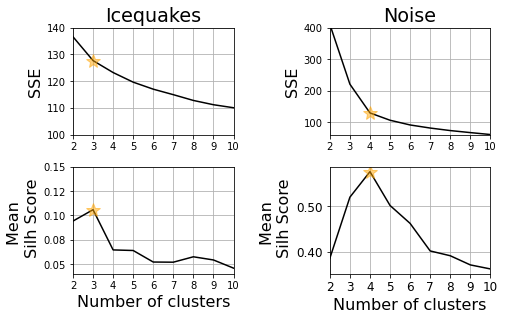

In [43]:
## Plot PCA by datetime, show rep events
from matplotlib.ticker import FormatStrFormatter

tfont=14
plt.rcParams.update({'font.size': 16})

Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


xlabelsize=10



print(Kopt,KoptN)


xlabelsize=10

fig,axes = plt.subplots(figsize = (width2,height1))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')




### Plot silh Scores
ax = fig.add_subplot(221)
figureFunctions2.plotSSE(Kopt, sse, range_n_clusters_all,starSize=15,ax=ax)
ax.set_title('Icequakes')
ax.set_ylabel('SSE')
ax.set_ylim(100,140)
ax.set_xlim(2,10)
ax.set_xlabel('')
# ax.set_xticklabels([])
ax.tick_params(axis='both', which='major', labelsize=10)



ax = fig.add_subplot(222)
figureFunctions2.plotSSE(KoptN, sseN, range_n_clusters_all,starSize=15,ax=ax)
ax.set_title('Noise')
ax.set_ylabel('SSE')
ax.set_ylim(60,400)
ax.set_xlim(2,10)
ax.set_xlabel('')
# ax.set_xticklabels([])
ax.tick_params(axis='both', which='major', labelsize=10)



### Plot silh Scores
ax = fig.add_subplot(223)
figureFunctions2.plotSilhScore(Kopt, avgSils, range_n_clusters_all,starSize=15,ax=ax)
ax.set_ylabel('Mean \n Silh Score')
ax.set_xlim(2,10)
ax.set_ylim(.04,.15)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax = fig.add_subplot(224)
figureFunctions2.plotSilhScore(KoptN, avgSilsN, range_n_clusters_all,starSize=15,ax=ax)
ax.set_ylabel('Mean \n Silh Score')
ax.set_xlim(2,10)
# ax.set_ylim(.55,.65)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.savefig(pathFig + 'Figure_5_silhScore.png', dpi=300)

plt.subplots_adjust(wspace=.6,hspace=0.3)




plt.savefig(pathFig + 'stats2.png', dpi=300,bbox_inches='tight')

# '10_clusterSeason.png'

In [44]:
cat00N.columns

Index(['year', 'month', 'day', 'hour', 'mn', 'sec', 'event_ID', 'doy',
       'datetime', 'PC1', 'PC2', 'PC3', 'hod', 'datenum', 'Cluster', 'SS',
       'euc_dist'],
      dtype='object')

In [45]:
try:
    cat00['datetime_index'] =  [pd.Timestamp(d) for d in cat00.datetime_index]
    cat00.set_index('datetime_index',inplace=True)
except:
    pass

try:
    cat00N['datetime_index'] =  [pd.Timestamp(d) for d in cat00N.datetime_index]
    cat00N.set_index('datetime_index',inplace=True)
except:
    pass


In [46]:
cat00.index

DatetimeIndex(['2007-06-14 09:30:58', '2007-06-14 11:31:25',
               '2007-06-14 12:03:56', '2007-06-14 12:07:17',
               '2007-06-14 12:10:58', '2007-06-14 14:07:24',
               '2007-06-14 15:59:22', '2007-06-14 17:19:39',
               '2007-06-15 06:22:18', '2007-06-15 06:46:34',
               ...
               '2007-07-21 15:01:40', '2007-07-21 15:10:23',
               '2007-07-21 15:17:01', '2007-07-21 15:58:33',
               '2007-07-21 16:17:23', '2007-07-21 16:56:23',
               '2007-07-21 17:11:34', '2007-07-21 17:15:16',
               '2007-07-21 19:21:46', '2007-07-21 19:35:14'],
              dtype='datetime64[ns]', name='datetime_index', length=1457, freq=None)

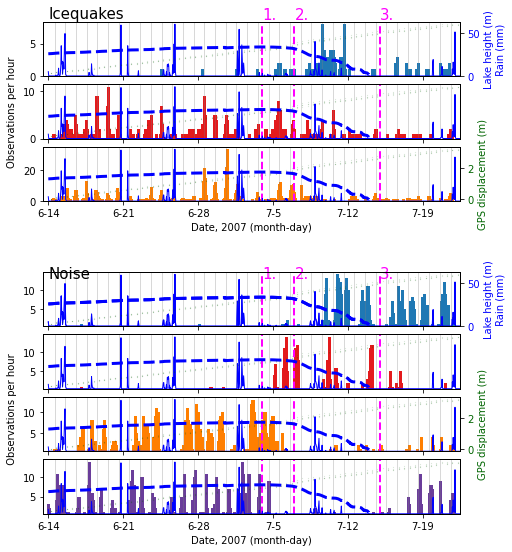

In [174]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 10})
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)



gs = gridspec.GridSpec(KoptN+Kopt+1,1)
gs.update(wspace=.6, hspace=.15)

tpad = 6


gpsstations = [24,34,36,37]

timecode = '3H'
datatype = ''


title = 'Icequakes'
textY = 16  
ymax = 8.7

texty = 15

for k in range(1,Kopt+1):
    
    ax=plt.subplot(gs[k-1,0])

    figureFunctions2.plotBarCluster(cat00,k=k,barWidth=.3,timeBin='H',ax=ax,**plt_kwargs)

    
    if k == 1:

        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)  
        
        ##title
        ax.text(x=datetime.datetime(2007,6,14),y= ymax+.2, s='Icequakes',color='k',size=texty)

        ax.text(x=supraDraint,y= ymax, s='1.',color='fuchsia',size=texty)
        ax.text(x=subDraint,y= ymax,s='2.',color='fuchsia',size=texty)
        ax.text(x=drainEndt,y= ymax,s='3.',color='fuchsia',size=texty)
   


        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
    
    elif k==2:    
        ax.set_ylabel('Observations per hour',labelpad=6) 
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='none',ax=ax,**plt_kwargs)
        
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
            
            
    elif k==3:
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='right',size=.1,ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='none',ax=ax,**plt_kwargs)
    
    else:
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='none',ax=ax,**plt_kwargs)
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
            
        ## lol 3 for alpha
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)  
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)   
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)               
        
    
    ax.axvline(x=subDraint,color='fuchsia',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,color='fuchsia',linestyle='--',linewidth=2, alpha=1)   
    ax.axvline(x=drainEndt,color='fuchsia',ls='--',linewidth=2)


    if k == Kopt:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

        
        
ax=plt.subplot(gs[Kopt,0])
ax.axis('off')






titleN = 'Noise'
textYN = 17
# ymaxN = 18
ymaxN = 13

for k in range(1,KoptN+1):
    
    ax=plt.subplot(gs[k-1+Kopt+1,0])
#     ax.set_ylim(ymin=0)

    figureFunctions2.plotBarCluster(cat00N,k=k,barWidth=.3,ax=ax,**plt_kwargs)
    ## lol 3 for alpha
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)  
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)   
#     figureFunctions2.plotTemp(meteor_df.temp,ax=ax,labels='off',**plt_kwargs)   
    


    
    
    ax.axvline(x=subDraint,color='fuchsia',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,color='fuchsia',linestyle='--',linewidth=2, alpha=1)   
    ax.axvline(x=drainEndt,color='fuchsia',ls='--',linewidth=2)
    
    
    if k == 1:
        ax.set_xlabel('')
        ax.set_xticklabels('')
#         ax.set_title(titleN,fontsize=tfont,pad=tpad)

        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)

        
        
        ###TITLE
        ax.text(x=datetime.datetime(2007,6,14),y= ymaxN, s='Noise',color='k',size=texty)
        
        
        ax.text(x=supraDraint,y= ymaxN, s='1.',color='fuchsia',size=texty)
        ax.text(x=subDraint,  y= ymaxN,s='2.',color='fuchsia',size=texty)
        ax.text(x=drainEndt,  y= ymaxN,s='3.',color='fuchsia',size=texty)
   
    if k == 3:

        ax.set_ylabel('          Observations per hour',labelpad=6)  
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel=None,ax=ax,**plt_kwargs)
        
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='right',size=.1,ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)
    else:
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel=None,ax=ax,**plt_kwargs)
        
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.gps_roll,ylabel='none',size=.1,ax=ax,**plt_kwargs)

    if k == KoptN:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
    ax.set_ylim(bottom=.5)
    
        
plt.savefig(pathFig + f'10_clusterSeason.png', dpi=300, bbox_inches='tight')

# Figure 6 rep wf spectra and reconstructed spectra

In [48]:
# ## Takes awhile! Already calculated ..... 


# # Finding CC and Lag matrices for top {20} events
shift_cc = lenData
shift_ccN = lenDataN

print(f'calculating IQ CC topF = {topF}...')
cc_mat,lag_mat = calcCCMatrix(catRep,lenData,dataH5_path,station,channel,fmin,fmax,fs)




# print(f'calculating NS CC topF = {topF}...')

# cc_matN,lag_matN = calcCCMatrix(catRepN,lenDataN,dataH5_pathN,station,channel,fminN,fmaxN,fsN)

print(f'saving...')




calculating IQ CC topF = 30...
saving...


In [49]:
np.save(f'../01_input/data/interim/{key}_ccLagMat_top{topF}_SS.npy',lag_mat)
np.save(f'../01_input/data/interim/{key}_ccMat_top{topF}_SS.npy',cc_mat)

# np.save(f'../01_input/data/interim/{keyN}_ccLagMat_top{topF}_SS_N.npy',lag_matN)
# np.save(f'../01_input/data/interim/{keyN}_ccMat_top{topF}_SS_N.npy',cc_matN)

## Load cc matrices

In [50]:
# lag_mat  = np.load(f'../01_input/data/interim/{key}_ccLagMat_top{topF}_SS.npy')
# cc_mat = np.load(f'../01_input/data/interim/{key}_ccMat_top{topF}_SS.npy')


# # lag_matN = np.load(f'../01_input/data/interim/{keyN}_ccLagMat_top{topF}_SS_N.npy')
# # cc_matN = np.load(f'../01_input/data/interim/{keyN}_ccMat_top{topF}_SS_N.npy')

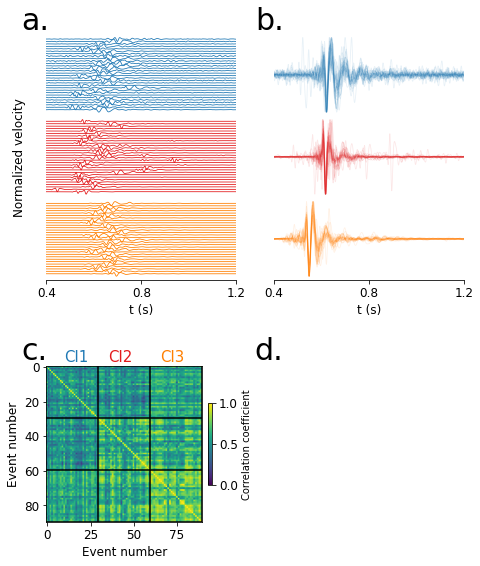

In [51]:
plt.rcParams.update({'font.size': 12})


## mute depreciation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(6,2)


tfont = 14
lw=.8
alpha=1
    

    
    
    #events
for i, evID in enumerate(catRep.event_ID):    

#     if k ==1 :
#         ax.set_title(f'Icequakes, n={len(catRep)}', fontsize=tfont,pad=15)
        
        
    date_str = str(catRep.datetime.iloc[i])[5:]
    k = catRep.Cluster.iloc[i]
    ax=plt.subplot(gs[k-1,0:1]);
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    
    ax.set_ylabel('')
    ax.set_yticklabels('')        
    ax.set_yticks([])  
    
    ax.set_xlabel('')
    ax.set_xticklabels('')        
    ax.set_xticks([])      
    
    lag0 = lag_mat[(k-1)*5,:] ## get template for each cluster
    
    
    # load wf from H5
    wf = getWF(str(evID),dataH5_path,station,channel,fmin,fmax,fs)
    
    #Norm by max and zero mean
    wf_norm = wf / np.max(np.abs(wf))
    wf_zeromean = wf_norm - np.mean(wf_norm)
    
    offset = 1
    wf_offset = (wf_zeromean) + i*offset#1.5
    
#     waveform_shift = lagWF(wf_offset, lag0, index_wf=i)
    ##plot !!

    plt.plot(wf_offset,lw=.8,alpha=alpha,c=colors[k-1])

    if k==2:
        ax.set_ylabel('Normalized velocity',labelpad=20)

    if k==Kopt:
        ax.set_xticks([400,800,1200])
        ax.set_xticklabels([0.4,0.8,1.2])  
        plt.xlabel('t (s)')
        
        
    plt.xlim(0,len(wf_zeromean))


    
    xmin = 400
    xmax = 1200
    plt.xlim(xmin,xmax)

    
ax.spines['bottom'].set_visible(True)    
    
    
    

    
    
    ## close up, no offest
    #events
for i, evID in enumerate(catRep.event_ID):    

#     if k ==1 :
#         ax.set_title(f'Icequakes, n={len(catRep)}', fontsize=tfont,pad=15)
        
        
    date_str = str(catRep.datetime.iloc[i])[5:]
    k = catRep.Cluster.iloc[i]
    ax=plt.subplot(gs[k-1,1:2]);
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    
    ax.set_ylabel('')
    ax.set_yticklabels('')        
    ax.set_yticks([])  
    
    ax.set_xlabel('')
    ax.set_xticklabels('')        
    ax.set_xticks([])      
    
    lag0 = lag_mat[(k-1)*5,:] ## get template for each cluster
    
    
    # load wf from H5
    wf = getWF(str(evID),dataH5_path,station,channel,fmin,fmax,fs)
    
    #Norm by max and zero mean
    wf_norm = wf / np.max(np.abs(wf))
    wf_zeromean = wf_norm - np.mean(wf_norm)
    
    offset = 0
    wf_offset = (wf_zeromean) + i*offset#1.5
    
    waveform_shift = lagWF(wf_offset, lag0, index_wf=i)
    ##plot !!

    plt.plot(waveform_shift,lw=.8,alpha=.1,c=colors[k-1])

#     if k==2:
#         ax.set_ylabel('Normalized velocity',labelpad=20)

    if k==Kopt:
        ax.set_xticks([400,800,1200])
        ax.set_xticklabels([0.4,0.8,1.2])  
        plt.xlabel('t (s)')
        
        
    plt.xlim(0,len(wf_zeromean))


    
    xmin = 400
    xmax = 1200
    plt.xlim(xmin,xmax)
  
    
    
ax.spines['bottom'].set_visible(True)
# ax.set_title('b.',fontsize=atext,loc='left')
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### CC Matrix
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


gs.update(wspace=.2,hspace=0)


ax=plt.subplot(gs[4:,0:1]);


plt.rcParams['image.cmap']='viridis'#'hsv'#'magma'#'viridis'#'hsv'#'RdBu'


plt.imshow(cc_mat)
cbar = plt.colorbar(pad=.03,shrink=.5)
cbar.set_label('Correlation coefficient',labelpad=4,fontsize = 10)

plt.clim(0,1)

ax.set_xlabel('Event number')
ax.set_ylabel('Event number')

for kk in range(1,Kopt+1):
    
    ax.axvline(kk * topF - .5,color='k')
    ax.axhline(kk * topF - .5,color='k')

    
ttt = 15
sss = 30
ax.text(10,-3,'Cl1',color=colors[0],fontsize=ttt)
ax.text(35,-3,'Cl2',color=colors[1],fontsize=ttt)
ax.text(65,-3,'Cl3',color=colors[2],fontsize=ttt)


ax.text(-15,-195,'a.',color='k',fontsize=sss)
ax.text(120,-195,'b.',color='k',fontsize=sss)
ax.text(-15,-4,'c.',color='k',fontsize=sss)
ax.text(120,-4,'d.',color='k',fontsize=sss)

# ax.set_title('c.',fontsize=atext,loc='left')





gs.update(wspace=.2,hspace=0)## hspace must equal 0


plt.savefig(pathFig+ f'06_wf_noStack_CC.png', dpi=300,bbox_inches='tight')

# Calc stats for stations




In [52]:
path_WF

'/Users/theresasawi/Documents/SpecUFEx_v1/BB_Gorner_Event_Redo_v2/01_input/J8/waveforms/'

In [53]:
import warnings
warnings.filterwarnings("ignore") ## was giving warning for nfft

cat00['datetime'] = cat00['date_index']
cat00['event_ID'] = ['0' + str(ev) for ev in cat00['event_ID']] ## have to add tis fo rthe location stats
df_stat = getFeatures_Explore(cat00,path_WF,'gse2',fmin,fmax,fs,nfft);
df_statN = getFeatures_Explore(cat00N,path_WFN,'sac',fminN,fmaxN,fs,nfftN);

df_loc = getLocationFeatures(cat00,stn,station)
cat00['event_ID'] = [ev[1:] for ev in cat00['event_ID']]


0 / 1457
100 / 1457
200 / 1457
300 / 1457
400 / 1457
500 / 1457
600 / 1457
700 / 1457
800 / 1457
900 / 1457
1000 / 1457
1100 / 1457
1200 / 1457
1300 / 1457
1400 / 1457
0 / 1472
100 / 1472
200 / 1472
300 / 1472
400 / 1472
500 / 1472
600 / 1472
700 / 1472
800 / 1472
900 / 1472
1000 / 1472
1100 / 1472
1200 / 1472
1300 / 1472
1400 / 1472


## Load stats for ALLL DATA!

In [54]:
df_loc.to_csv(f'../01_input/data/interim/{key}_df_locALL.csv')
df_statN.to_csv(f'../01_input/data/interim/{keyN}_df_statALLN.csv')
df_stat.to_csv(f'../01_input/data/interim/{key}_df_statALL.csv')

In [55]:
# df_stat = pd.read_csv(f'../01_input/data/interim/{key}_df_statALL.csv')
# df_statN = pd.read_csv(f'../01_input/data/interim/{keyN}_df_statALLN.csv')
# df_loc = pd.read_csv(f'../01_input/data/interim/{key}_df_locALL.csv')


# # df_loc.to_csv(f'../data/interim/d{key}_f_locALL.csv')
# # dfN.to_csv(f'../data/interim/{key}_df_statALLN.csv')
# # df.to_csv(f'../data/interim/{key}_df_statALL.csv')

## merge to cat00



In [56]:
df_stat

,ev_ID,log10RSAM,SC,log10P2P,log10Var,Kurt,DomFreq,Cluster
datetime,,,,,,,,
2007-06-14 09:30:58,070614093058,6.390658,27.737431,4.879007,7.293445,39.513079,334.228516,3
2007-06-14 11:31:25,070614113125,5.577314,34.478367,4.083774,5.648213,53.804860,320.068359,3
2007-06-14 12:03:56,070614120356,5.766330,35.992756,4.295577,6.111563,41.804631,298.583984,3
2007-06-14 12:07:17,070614120717,6.744162,44.076406,5.543745,8.348489,96.495032,266.601562,2
2007-06-14 12:10:58,070614121058,6.110908,49.149781,4.966648,7.116996,134.517541,270.751953,3
...,...,...,...,...,...,...,...,...
2007-07-21 16:56:23,070721165623,5.598450,36.589888,3.848982,5.428521,24.143293,346.679688,3
2007-07-21 17:11:34,070721171134,6.240911,28.710428,4.696144,6.920004,42.189396,367.919922,3
2007-07-21 17:15:16,070721171516,6.022351,30.981056,4.484982,6.467768,40.953193,335.449219,3


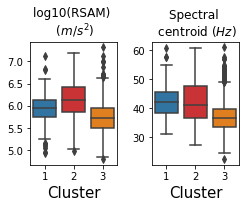

In [57]:
plt.rcParams.update({'font.size': 10})

fig,axes = plt.subplots(figsize = (width2/2,height2/4))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(1,2)



### ### ### ### ### ### ### ### ### ### ### ### 
### ### ### ### ### ### ### ### ### ### ### ### 
## plot boxplot for RSAM
ax = plt.subplot(gs[0])

figureFunctions2.plotFeatureBoxPlot(df_stat,Kopt,'log10RSAM',ax=ax,**plt_kwargs)
ax.set_title('log10(RSAM) \n ($m/s^2$)')
ax.set_xlabel('Cluster',labelpad=4,fontsize=15)

# ax.set_xticks([])
# ax.set_xticklabels('')
ax.set_ylabel('')
# ax.grid('off')



### ### ### ### ### ### ### ### ### ### ### ### 
## plot Boxplot for SC
ax = plt.subplot(gs[1])
figureFunctions2.plotFeatureBoxPlot(df_stat,Kopt,'SC',ax=ax,**plt_kwargs)


ax.set_ylabel('')
ax.set_xlabel('Cluster',labelpad=4,fontsize=15)
ax.set_title('Spectral \n centroid ($Hz$)')
# ax.set_xticks([])

gs.update(wspace=.4,hspace=0)
plt.savefig(pathFig+ f'06_box_inset_3.png', dpi=300,bbox_inches='tight')

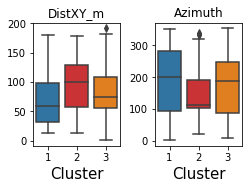

In [58]:
plt.rcParams.update({'font.size': 10})

fig,axes = plt.subplots(figsize = (width2/2,height2/4))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(1,2)



### ### ### ### ### ### ### ### ### ### ### ### 
### ### ### ### ### ### ### ### ### ### ### ### 
## plot boxplot for RSAM
ax = plt.subplot(gs[0])

figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'DistXY_m',ax=ax,**plt_kwargs)
ax.set_title('DistXY_m')
ax.set_xlabel('Cluster',labelpad=4,fontsize=15)

# ax.set_xticks([])
# ax.set_xticklabels('')
ax.set_ylabel('')
# ax.grid('off')



### ### ### ### ### ### ### ### ### ### ### ### 
## plot Boxplot for SC
ax = plt.subplot(gs[1])
figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'Azimuth',ax=ax,**plt_kwargs)


ax.set_ylabel('')
ax.set_xlabel('Cluster',labelpad=4,fontsize=15)
ax.set_title('Azimuth')
# ax.set_xticks([])

gs.update(wspace=.4,hspace=0)
plt.savefig(pathFig+ f'06_box_inset_3b.png', dpi=300,bbox_inches='tight')

In [59]:
df_statN.columns

Index(['ev_ID', 'log10RSAM', 'SC', 'log10P2P', 'log10Var', 'Kurt', 'DomFreq',
       'Cluster'],
      dtype='object')

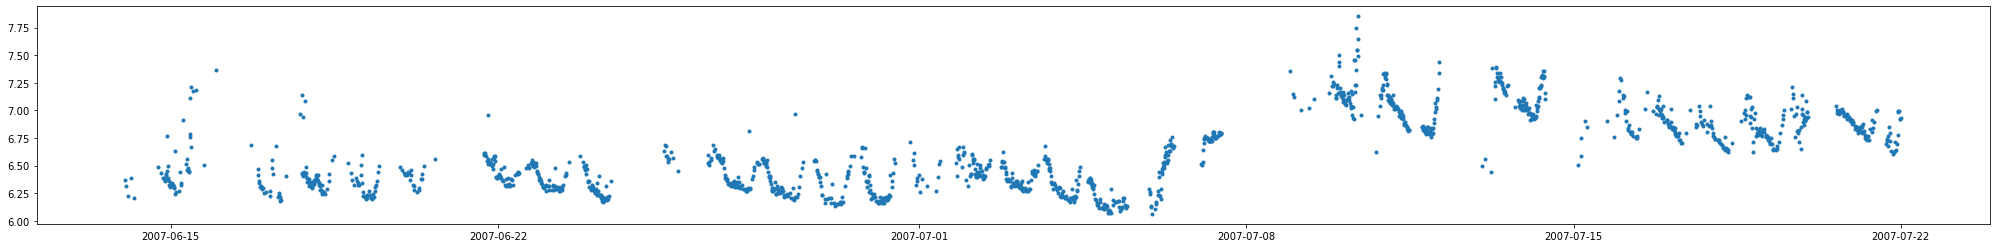

In [60]:
plt.figure(figsize=(35,4))
plt.plot(df_statN.log10RSAM,ls='none',marker='.')

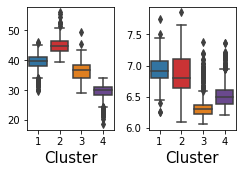

In [198]:
catRepN_stats = df_statN[df_statN.ev_ID.isin(list(catRepN.event_ID))]
plt.rcParams.update({'font.size': 10})

fig,axes = plt.subplots(figsize = (width2/2,height2/4))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(1,2)



### ### ### ### ### ### ### ### ### ### ### ### 
### ### ### ### ### ### ### ### ### ### ### ### 
## plot boxplot for RSAM
ax = plt.subplot(gs[0])

figureFunctions2.plotFeatureBoxPlot(df_statN,KoptN,'SC',ax=ax,**plt_kwargs)
# ax.set_title('DistXY_m')
ax.set_xlabel('Cluster',labelpad=4,fontsize=15)

# ax.set_xticks([])
# ax.set_xticklabels('')
ax.set_ylabel('')
# ax.grid('off')



### ### ### ### ### ### ### ### ### ### ### ### 
## plot Boxplot for SC
ax = plt.subplot(gs[1])
figureFunctions2.plotFeatureBoxPlot(df_statN,KoptN,'log10RSAM',ax=ax,**plt_kwargs)


ax.set_ylabel('')
ax.set_xlabel('Cluster',labelpad=4,fontsize=15)
# ax.set_title('Azimuth')
# ax.set_xticks([])

gs.update(wspace=.4,hspace=0)
plt.savefig(pathFig+ f'06_box_inset_na.png', dpi=300,bbox_inches='tight')

## Noise waveforms

# Bonus figure! Analyzing noise 

FileNotFoundError: [Errno 2] No such file or directory: '../01_input/data/interim/BB_Gorner_Cont_Redo_v5_ccMat_top30N.npy'

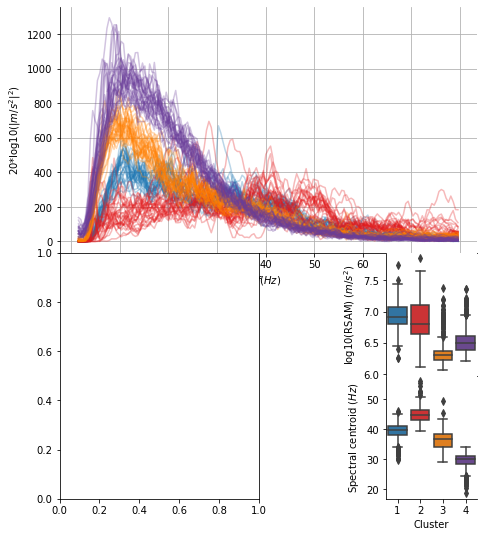

In [169]:
# plt.rcParams.update({'font.size': 8})


## mute depreciation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(4,4)


tfont = 14
lw=.8
alpha=1
    

## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA
## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA

# ax.axis('off')
ax=plt.subplot(gs[0:2,0:])    


for k in range(1,KoptN+1):
# for k in range(KoptN,-1,-1):

    
    catRepK = catRepN[catRepN.Cluster==k]

        

    for i, evID in enumerate(catRepK.event_ID):
        evID = int(evID)
        matSum, specMat = getSpectra(evID,station,path_projN,normed=True)
        ax.plot(fSTFTN,matSum,lw=1.5,c=colors[k-1],alpha=.3)
        plt.grid('on')
        

        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)        
    ax.spines['bottom'].set_visible(True)

    ax.set_ylabel("20*log10(|$m/s^2$|$^2$)")
    ax.set_xlabel('$f (Hz)$',labelpad=4)   
    
    
    

    
    

### ### ### ### ### ### ### ### ### ### ### ### 
### ### ### ### ### ### ### ### ### ### ### ### 
## plot boxplot for RSAM
ax = plt.subplot(gs[2,3])

figureFunctions2.plotFeatureBoxPlot(df_statN,KoptN,'log10RSAM',ax=ax,**plt_kwargs)
ax.set_ylabel('log10(RSAM) ($m/s^2$)',labelpad=5)
# ax.set_xticks([])
# ax.set_xticklabels('')
ax.set_xlabel('')
# ax.grid('off')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)     


### ### ### ### ### ### ### ### ### ### ### ### 
## plot Boxplot for SC
ax = plt.subplot(gs[3,3])
figureFunctions2.plotFeatureBoxPlot(df_statN,KoptN,'SC',ax=ax,**plt_kwargs)

gs.update(wspace=.8,hspace=0)
# ax.set_xlabel('Cluster',labelpad=4,fontsize=FS)
ax.set_ylabel('Spectral centroid ($Hz$)',labelpad=5)
# ax.set_xticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)    




####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### CC Matrix
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


gs.update(wspace=.2,hspace=0)


ax=plt.subplot(gs[2:,0:2]);

cc_mat = np.load(f'../01_input/data/interim/{keyN}_ccMat_top{topF}N.npy')

plt.rcParams['image.cmap']='RdBu'#'hsv'#'magma'#'viridis'#'hsv'#'RdBu'


plt.imshow(cc_mat)
cbar = plt.colorbar(pad=.1,shrink=.6)
cbar.set_label('Correlation coefficient',labelpad=4,fontsize = 10)

plt.clim(-1,1)

ax.set_xlabel('Event number')
ax.set_ylabel('Event number')

for kk in range(1,Kopt+1):
    
    ax.axvline(kk * topF - .5,color='k')
    ax.axhline(kk * topF - .5,color='k')

    
ttt = 15
sss = 30

ax.text(5,-3,'Cl1',color=colors[0],fontsize=ttt)
ax.text(25,-3,'Cl2',color=colors[1],fontsize=ttt)
ax.text(45,-3,'Cl3',color=colors[2],fontsize=ttt)
ax.text(65,-3,'Cl4',color=colors[3],fontsize=ttt)


ax.text(-25,-150,'a.',color='k',fontsize=sss)
ax.text(-25,-4,'b.',color='k',fontsize=sss)
ax.text(120,-4,'c.',color='k',fontsize=sss)


gs.update(wspace=0,hspace=0.3)
    

plt.savefig(pathFig+ f'07_NoiseResults.png', dpi=300)

# Import df_roll_list from notebook plotFigures_CloseUpTimeline

# Add hours to df_statN

In [200]:
df_statN


,datetime,ev_ID,log10RSAM,SC,log10P2P,log10Var,Kurt,DomFreq,Cluster
0,2007-06-14 00:40:00,70614004000,6.372330,29.543395,2.879751,3.415957,1.717725,315.429688,4
1,2007-06-14 01:07:00,70614010700,6.314863,30.833800,2.810376,3.283037,0.970212,93.750000,4
2,2007-06-14 01:55:00,70614015500,6.228021,31.638606,2.746152,3.121036,2.081610,247.558594,4
3,2007-06-14 03:27:59,70614032759,6.390384,28.190129,2.810633,3.462574,2.234798,245.117188,4
4,2007-06-14 04:52:00,70614045200,6.204325,33.418109,2.740834,3.107487,3.998076,124.511719,4
...,...,...,...,...,...,...,...,...,...
1467,2007-07-21 22:42:59,70721224259,6.997469,23.600330,3.323450,4.642061,0.279020,38.574219,4
1468,2007-07-21 22:56:00,70721225600,6.996496,24.138042,3.642107,4.677167,6.006233,72.265625,4
1469,2007-07-21 23:36:00,70721233600,6.918751,30.910891,3.408911,4.491416,0.926070,344.238281,1
1470,2007-07-21 23:47:00,70721234700,6.922835,31.222069,3.289787,4.500059,0.604042,329.589844,1


In [201]:
df_statN['datetime'] = [pd.Timestamp(d) for d in df_statN.datetime]
df_statN['datetime']
df_statN.set_index('datetime',inplace=True)


In [192]:
from matplotlib.colors import LinearSegmentedColormap

colors2 = colors[0:4,:]

n_bins = range(1,KoptN+1)  # Discretizes the interpolation into bins
cmap_name = 'mycmap'
for n_bin in n_bins:
    # Create the colormap
    cmap2 = LinearSegmentedColormap.from_list(cmap_name, colors2, N=n_bin)
    # Fewer bins will result in "coarser" colomap interpolation

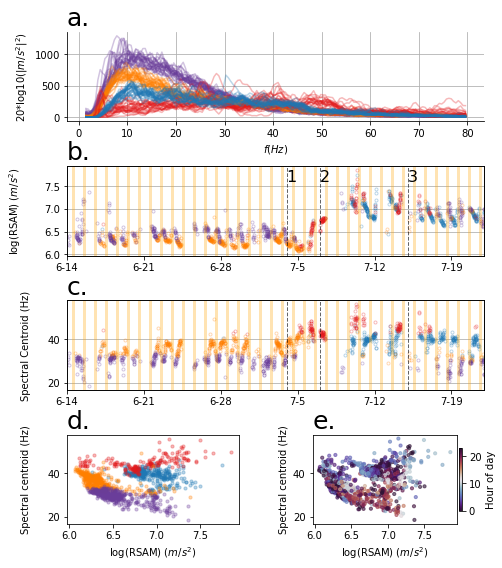

In [149]:
# plt.rcParams.update({'font.size': 8})


## mute depreciation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(8,4)


tfont = 14
lw=.8
alpha=1
alphaT = .6

## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA
## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA

# ax.axis('off')
ax=plt.subplot(gs[0:2,0:])    


# for k in range(1,KoptN+1):
for k in range(KoptN,0,-1):

# for k in range(KoptN,-1,-1):

    
    catRepK = catRepN[catRepN.Cluster==k]

        

    for i, evID in enumerate(catRepK.event_ID):
        evID = int(evID)
        matSum, specMat = getSpectra(evID,station,path_projN,normed=False)
        ax.plot(fSTFTN,matSum,lw=1.5,c=colors[k-1],alpha=.3)
        plt.grid('on')
        

        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)        
    ax.spines['bottom'].set_visible(True)

    ax.set_ylabel("20*log10(|$m/s^2$|$^2$)")
    ax.set_xlabel('$f (Hz)$',labelpad=4)   
    
#     plt.xscale('log')
ax.set_title('a.',fontsize=atext,loc='left')


####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### RSAM
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[2:4,0:]);


lw2=1

# for clus in range(KoptN,0,-1):
for clus in range(1,KoptN+1):

    feature = 'log10RSAM'

    size=3
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    ax.plot(dff[feature],
          linestyle='none',
          marker='o',
          markeredgecolor=cluscolor,
          markerfacecolor='none',
          markeredgewidth=1,            
          alpha=.3,
          ms=size)
    
lc = 'k'
ff=16
yy=7.6
ax.axvline(supraDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.axvline(subDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.axvline(drainEndt,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.text(supraDraint,yy,'1',fontsize=ff)
ax.text(subDraint,yy,'2',fontsize=ff)
ax.text(drainEndt,yy,'3',fontsize=ff)
ax.set_ylabel('log(RSAM) ($m/s^2$)', labelpad=21)


ax.yaxis.grid()
for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='orange',linestyle='-',linewidth=3,alpha=0.3)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax=plt.gca()
ax.set_xlim(tstart,tend)
ax.set_xticks(day_ticks)
ax.set_xticklabels(day_labels)
ax.set_title('b.',fontsize=atext,loc='left')
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### SC
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax2=plt.subplot(gs[4:6,0:]);



# for clus in range(KoptN,0,-1):
for clus in range(1,KoptN+1):


    feature = 'SC'

    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    ax2.plot(dff[feature],
          linestyle='none',
          marker='o',
          markeredgecolor=cluscolor,
          markerfacecolor='none',
          markeredgewidth=1,
          alpha=.3,
          ms=size)
    

# for i in range(0,1):
#     df_roll_list[i].z_roll.plot(color='limegreen',ax=ax3)
#     df_roll_list[i].z_roll.plot(color='limegreen',ax=ax4)
    
lc = 'k'
ax2.axvline(supraDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax2.axvline(subDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax2.axvline(drainEndt,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)

ax2.yaxis.grid()
for i in range(numDays):
    ax2.axvline(hourMaxTemp[i],c='orange',linestyle='-',linewidth=3,alpha=0.3)

for tick in ax2.get_xticklabels():
    tick.set_rotation(0)

ax2.set_xlim(tstart,tend)
ax2.set_xticks(day_ticks)
ax2.set_xticklabels(day_labels)
#     plt.tight_layout()
# plt.ylim(-1e7,train_set['log10abs_sum'].max())
ax2.set_ylabel('Spectral Centroid (Hz)', labelpad=16)

ax5 = ax.twinx()
ax5.set_yticks([])
ax5.set_yticklabels([])


ax6 = ax2.twinx()
ax6.set_yticks([])
ax6.set_yticklabels([])

# figureFunctions2.plotLake(lake_df,meteor_df.rain,ax=ax5,**plt_kwargs)
# figureFunctions2.plotLake(lake_df,meteor_df.rain,ax=ax6,**plt_kwargs)


ax2.set_xticks(day_ticks)
ax2.set_xticklabels(day_labels)

ax2.set_title('c.',fontsize=atext,loc='left')
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 1: cluster 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[6:,0:2]);




# for clus in range(KoptN,0,-1):
for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    ax.scatter(dff[feature1],dff[feature2],color=cluscolor,alpha=.3,s=10)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)', labelpad=16)
ax.set_title('d.',fontsize=atext,loc='left')




####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 2: Time of Day
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


ax=plt.subplot(gs[6:,2:]);



sm = plt.cm.ScalarMappable(cmap='twilight_shifted',
                       norm=plt.Normalize(vmin=min(df_statN.index.hour),vmax=max(df_statN.index.hour)))
cbar = plt.colorbar(sm,label='Hour of day',orientation='vertical',shrink=.7,pad=.01);

for clus in range(KoptN,0,-1):
# for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    
#     cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))
    
    
    
    ax.scatter(dff[feature1],dff[feature2],c=dff.index.hour,alpha=.6,s=10,cmap=cm.twilight_shifted)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)')


ax.set_title('e.',fontsize=atext,loc='left')



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Labels, etc
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ttt = 15
sss = 30

# ax.text(-25,-150,'a.',color='k',fontsize=sss)
# ax.text(-25,-4,'b.',color='k',fontsize=sss)
# ax.text(120,-4,'c.',color='k',fontsize=sss)


gs.update(wspace=1.5,hspace=2)
    

plt.savefig(pathFig+ f'07_NoiseResults_v2.png', dpi=300)

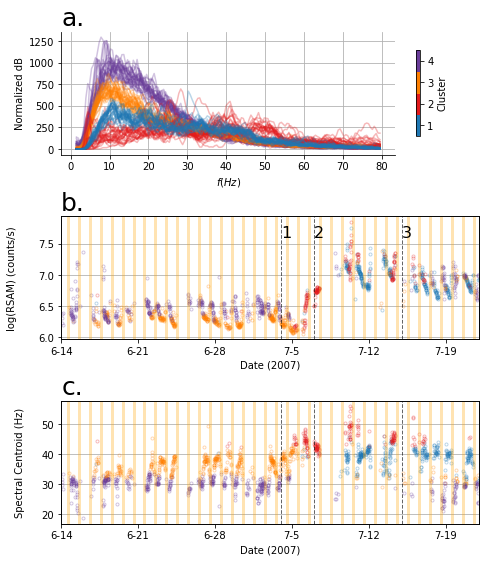

In [243]:
# plt.rcParams.update({'font.size': 8})


## mute depreciation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(6,4)


tfont = 14
lw=.8
alpha=1
alphaT = .6

## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA
## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA

# ax.axis('off')
ax=plt.subplot(gs[0:2,0:])    


# for k in range(1,KoptN+1):
for k in range(KoptN,0,-1):

# for k in range(KoptN,-1,-1):

    
    catRepK = catRepN[catRepN.Cluster==k]

        

    for i, evID in enumerate(catRepK.event_ID):
        evID = int(evID)
        matSum, specMat = getSpectra(evID,station,path_projN,normed=False)
        ax.plot(fSTFTN,matSum,lw=1.5,c=colors[k-1],alpha=.3)
        plt.grid('on')
        

        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)        
    ax.spines['bottom'].set_visible(True)

#     ax.set_ylabel("20*log10(|counts/s$^2$|$^2$)")
    ax.set_ylabel("Normalized dB")    
    
    ax.set_xlabel('$f (Hz)$',labelpad=4)   
    
#     plt.xscale('log')
ax.set_title('a.',fontsize=atext,loc='left')
sm = plt.cm.ScalarMappable(cmap=cmap2,norm=None)

# cbar = plt.colorbar(sm,label='Cluster',orientation='vertical',shrink=.7,pad=.1);
cbar = fig.colorbar(sm, ticks=[.125, .375, .625 , .875],label='Cluster',orientation='vertical',shrink=.7,pad=.05)
cbar.ax.set_yticklabels(['1', '2', '3','4'])  


####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### RSAM
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[2:4,0:]);


lw2=1

# for clus in range(KoptN,0,-1):
for clus in range(1,KoptN+1):

    feature = 'log10RSAM'

    size=3
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    ax.plot(dff[feature],
          linestyle='none',
          marker='o',
          markeredgecolor=cluscolor,
          markerfacecolor='none',
          markeredgewidth=1,            
          alpha=.3,
          ms=size)
    
lc = 'k'
ff=16
yy=7.6
ax.axvline(supraDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.axvline(subDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.axvline(drainEndt,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.text(supraDraint,yy,'1',fontsize=ff)
ax.text(subDraint,yy,'2',fontsize=ff)
ax.text(drainEndt,yy,'3',fontsize=ff)
ax.set_ylabel('log(RSAM) (counts/s)', labelpad=21)


ax.yaxis.grid()
for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='orange',linestyle='-',linewidth=3,alpha=0.3)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax=plt.gca()
ax.set_xlim(tstart,tend)
ax.set_xticks(day_ticks)
ax.set_xticklabels(day_labels)
ax.set_xlabel('Date (2007)')
ax.set_title('b.',fontsize=atext,loc='left')
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### SC
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax2=plt.subplot(gs[4:6,0:]);



# for clus in range(KoptN,0,-1):
for clus in range(1,KoptN+1):


    feature = 'SC'

    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    ax2.plot(dff[feature],
          linestyle='none',
          marker='o',
          markeredgecolor=cluscolor,
          markerfacecolor='none',
          markeredgewidth=1,
          alpha=.3,
          ms=size)
    

# for i in range(0,1):
#     df_roll_list[i].z_roll.plot(color='limegreen',ax=ax3)
#     df_roll_list[i].z_roll.plot(color='limegreen',ax=ax4)
    
lc = 'k'
ax2.axvline(supraDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax2.axvline(subDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax2.axvline(drainEndt,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)

ax2.yaxis.grid()
for i in range(numDays):
    ax2.axvline(hourMaxTemp[i],c='orange',linestyle='-',linewidth=3,alpha=0.3)

for tick in ax2.get_xticklabels():
    tick.set_rotation(0)

ax2.set_xlim(tstart,tend)
ax2.set_xticks(day_ticks)
ax2.set_xticklabels(day_labels)
#     plt.tight_layout()
# plt.ylim(-1e7,train_set['log10abs_sum'].max())
ax2.set_ylabel('Spectral Centroid (Hz)', labelpad=16)

ax5 = ax.twinx()
ax5.set_yticks([])
ax5.set_yticklabels([])


ax6 = ax2.twinx()
ax6.set_yticks([])
ax6.set_yticklabels([])

# figureFunctions2.plotLake(lake_df,meteor_df.rain,ax=ax5,**plt_kwargs)
# figureFunctions2.plotLake(lake_df,meteor_df.rain,ax=ax6,**plt_kwargs)


ax2.set_xticks(day_ticks)
ax2.set_xticklabels(day_labels)
ax2.set_xlabel('Date (2007)')
ax2.set_title('c.',fontsize=atext,loc='left')



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Labels, etc
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ttt = 15
sss = 30

# ax.text(-25,-150,'a.',color='k',fontsize=sss)
# ax.text(-25,-4,'b.',color='k',fontsize=sss)
# ax.text(120,-4,'c.',color='k',fontsize=sss)


gs.update(wspace=1.5,hspace=2)
    

plt.savefig(pathFig+ f'11a_NoiseResults_noHist.png', dpi=300)

# Just histereses

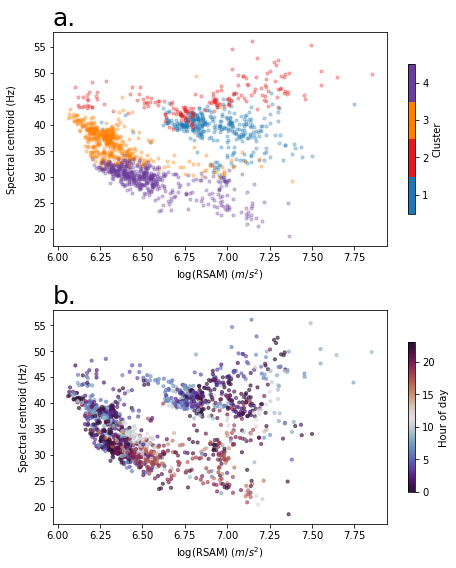

In [193]:

fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(2,1)



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 1: cluster 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[0]);







# for clus in range(KoptN,0,-1):
for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    cax = ax.scatter(dff[feature1],dff[feature2],color=cluscolor,alpha=.3,s=10)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)', labelpad=16)
ax.set_title('a.',fontsize=atext,loc='left')

sm = plt.cm.ScalarMappable(cmap=cmap2,norm=None)

# cbar = plt.colorbar(sm,label='Cluster',orientation='vertical',shrink=.7,pad=.1);
cbar = fig.colorbar(sm, ticks=[.125, .375, .625 , .875],label='Cluster',orientation='vertical',shrink=.7,pad=.05)
cbar.ax.set_yticklabels(['1', '2', '3','4'])  



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 2: Time of Day
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


ax=plt.subplot(gs[1]);



sm = plt.cm.ScalarMappable(cmap='twilight_shifted',
                       norm=plt.Normalize(vmin=min(df_statN.index.hour),vmax=max(df_statN.index.hour)))


cbar = plt.colorbar(sm,label='Hour of day',orientation='vertical',shrink=.7,pad=0.05);

for clus in range(KoptN,0,-1):
# for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    
#     cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))
    
    
    
    ax.scatter(dff[feature1],dff[feature2],c=dff.index.hour,alpha=.6,s=10,cmap=cm.twilight_shifted)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)')


ax.set_title('b.',fontsize=atext,loc='left')



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Labels, etc
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ttt = 15
sss = 30

# ax.text(-25,-150,'a.',color='k',fontsize=sss)
# ax.text(-25,-4,'b.',color='k',fontsize=sss)
# ax.text(120,-4,'c.',color='k',fontsize=sss)


gs.update(wspace=1.5,hspace=.3)
plt.savefig(pathFig + 'histereses.png', bbox_to_inches='tight', dpi = 300)

In [195]:
width1,height2

(3.74016, 9.05512)

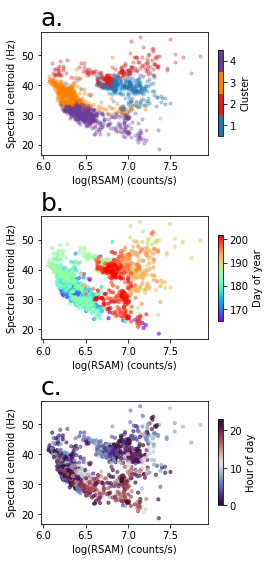

In [194]:


fig,axes = plt.subplots(figsize = (width1,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(3,1)



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 1: cluster 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[0]);







# for clus in range(KoptN,0,-1):
for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    cax = ax.scatter(dff[feature1],dff[feature2],color=cluscolor,alpha=.3,s=10)


ax.set_xlabel('log(RSAM) (counts/s)')
ax.set_ylabel('Spectral centroid (Hz)')
ax.set_title('a.',fontsize=atext,loc='left')

sm = plt.cm.ScalarMappable(cmap=cmap2,norm=None)

# cbar = plt.colorbar(sm,label='Cluster',orientation='vertical',shrink=.7,pad=.1);
cbar = fig.colorbar(sm, ticks=[.125, .375, .625 , .875],label='Cluster',orientation='vertical',shrink=.7,pad=.05)
cbar.ax.set_yticklabels(['1', '2', '3','4'])  



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 2: Time of Day
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


ax=plt.subplot(gs[1]);



sm = plt.cm.ScalarMappable(cmap='rainbow',
                       norm=plt.Normalize(vmin=min(df_statN.index.dayofyear),vmax=max(df_statN.index.dayofyear)))


cbar = plt.colorbar(sm,label='Day of year',orientation='vertical',shrink=.7,pad=0.05);

for clus in range(KoptN,0,-1):
# for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    
#     cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))
    
    
    
    ax.scatter(dff[feature1],dff[feature2],c=dff.index.dayofyear,alpha=.6,s=10,cmap=cm.rainbow)


ax.set_xlabel('log(RSAM) (counts/s)')
ax.set_ylabel('Spectral centroid (Hz)')


ax.set_title('b.',fontsize=atext,loc='left')


####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 2: Time of Day
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


ax=plt.subplot(gs[2]);



sm = plt.cm.ScalarMappable(cmap='twilight_shifted',
                       norm=plt.Normalize(vmin=min(df_statN.index.hour),vmax=max(df_statN.index.hour)))


cbar = plt.colorbar(sm,label='Hour of day',orientation='vertical',shrink=.7,pad=0.05);

for clus in range(KoptN,0,-1):
# for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN[df_statN.Cluster==clus]
    
#     cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))
    
    
    
    ax.scatter(dff[feature1],dff[feature2],c=dff.index.hour,alpha=.6,s=10,cmap=cm.twilight_shifted)


ax.set_xlabel('log(RSAM) (counts/s)')
ax.set_ylabel('Spectral centroid (Hz)')


ax.set_title('c.',fontsize=atext,loc='left')



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Labels, etc
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ttt = 15
sss = 30

# ax.text(-25,-150,'a.',color='k',fontsize=sss)
# ax.text(-25,-4,'b.',color='k',fontsize=sss)
# ax.text(120,-4,'c.',color='k',fontsize=sss)


gs.update(wspace=1.5,hspace=.5)




df_statN.index.dayofyear

plt.savefig(pathFig + 'histereses_doy.png', bbox_to_inches='tight', dpi = 300)

# Same plot, before drainage

In [153]:

df_statN_early = df_statN[df_statN.index < supraDraint]
df_statN_late = df_statN[df_statN.index > supraDraint]

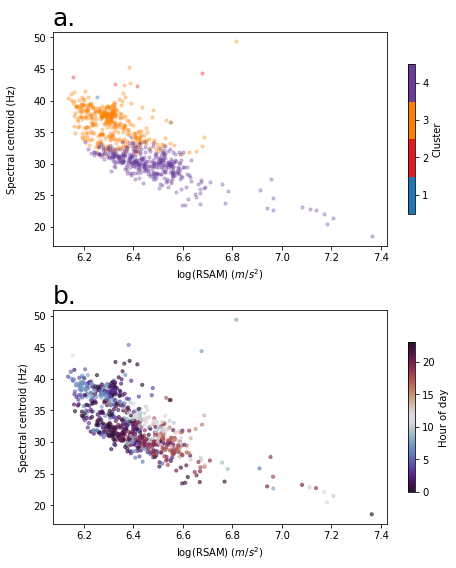

In [154]:

fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(2,1)



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 1: cluster 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[0]);







# for clus in range(KoptN,0,-1):
for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_early[df_statN_early.Cluster==clus]
    cax = ax.scatter(dff[feature1],dff[feature2],color=cluscolor,alpha=.3,s=10)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)', labelpad=16)
ax.set_title('a.',fontsize=atext,loc='left')

sm = plt.cm.ScalarMappable(cmap=cmap,norm=None)

# cbar = plt.colorbar(sm,label='Cluster',orientation='vertical',shrink=.7,pad=.1);
cbar = fig.colorbar(sm, ticks=[.125, .375, .625 , .875],label='Cluster',orientation='vertical',shrink=.7,pad=.05)
cbar.ax.set_yticklabels(['1', '2', '3','4'])  



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 2: Time of Day
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


ax=plt.subplot(gs[1]);



sm = plt.cm.ScalarMappable(cmap='twilight_shifted',
                       norm=plt.Normalize(vmin=min(df_statN.index.hour),vmax=max(df_statN.index.hour)))


cbar = plt.colorbar(sm,label='Hour of day',orientation='vertical',shrink=.7,pad=0.05);

for clus in range(KoptN,0,-1):
# for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_early[df_statN_early.Cluster==clus]
    
#     cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))
    
    
    
    ax.scatter(dff[feature1],dff[feature2],c=dff.index.hour,alpha=.6,s=10,cmap=cm.twilight_shifted)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)')


ax.set_title('b.',fontsize=atext,loc='left')



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Labels, etc
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ttt = 15
sss = 30

# ax.text(-25,-150,'a.',color='k',fontsize=sss)
# ax.text(-25,-4,'b.',color='k',fontsize=sss)
# ax.text(120,-4,'c.',color='k',fontsize=sss)


gs.update(wspace=1.5,hspace=.3)
plt.savefig(pathFig + 'histereses.png', bbox_to_inches='tight', dpi = 300)

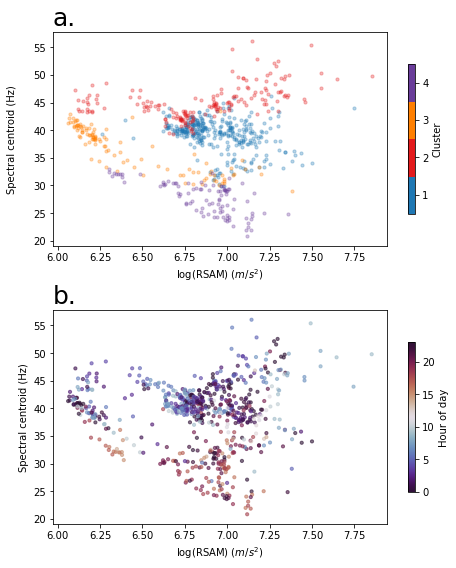

In [155]:

fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(2,1)



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 1: cluster 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[0]);







# for clus in range(KoptN,0,-1):
for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_late[df_statN_late.Cluster==clus]
    cax = ax.scatter(dff[feature1],dff[feature2],color=cluscolor,alpha=.3,s=10)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)', labelpad=16)
ax.set_title('a.',fontsize=atext,loc='left')

sm = plt.cm.ScalarMappable(cmap=cmap,norm=None)

# cbar = plt.colorbar(sm,label='Cluster',orientation='vertical',shrink=.7,pad=.1);
cbar = fig.colorbar(sm, ticks=[.125, .375, .625 , .875],label='Cluster',orientation='vertical',shrink=.7,pad=.05)
cbar.ax.set_yticklabels(['1', '2', '3','4'])  



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 2: Time of Day
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


ax=plt.subplot(gs[1]);



sm = plt.cm.ScalarMappable(cmap='twilight_shifted',
                       norm=plt.Normalize(vmin=min(df_statN.index.hour),vmax=max(df_statN.index.hour)))


cbar = plt.colorbar(sm,label='Hour of day',orientation='vertical',shrink=.7,pad=0.05);

for clus in range(KoptN,0,-1):
# for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_late[df_statN_late.Cluster==clus]
    
#     cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))
    
    
    
    ax.scatter(dff[feature1],dff[feature2],c=dff.index.hour,alpha=.6,s=10,cmap=cm.twilight_shifted)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)')


ax.set_title('b.',fontsize=atext,loc='left')



####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Labels, etc
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ttt = 15
sss = 30

# ax.text(-25,-150,'a.',color='k',fontsize=sss)
# ax.text(-25,-4,'b.',color='k',fontsize=sss)
# ax.text(120,-4,'c.',color='k',fontsize=sss)


gs.update(wspace=1.5,hspace=.3)
plt.savefig(pathFig + 'histereses.png', bbox_to_inches='tight', dpi = 300)

In [160]:
df_statN.index.dayofyear

Int64Index([165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
            ...
            202, 202, 202, 202, 202, 202, 202, 202, 202, 202],
           dtype='int64', name='datetime', length=1472)

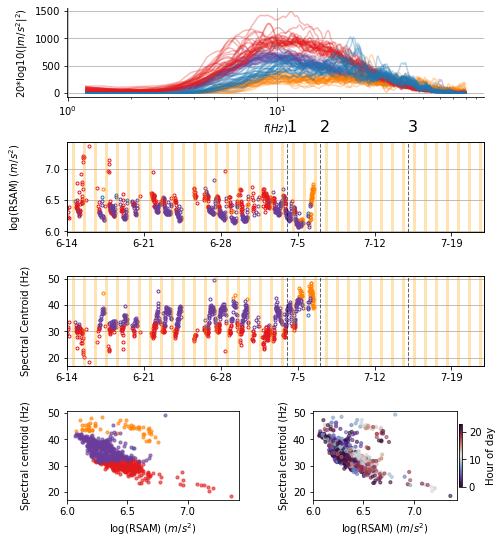

In [138]:
# plt.rcParams.update({'font.size': 8})


## mute depreciation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(8,4)


tfont = 14
lw=.8
alpha=1
alphaT = .6

## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA
## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA

# ax.axis('off')
ax=plt.subplot(gs[0:2,0:])    


# for k in range(1,KoptN+1):
for k in range(KoptN,0,-1):

# for k in range(KoptN,-1,-1):

    
    catRepK = catRepN[catRepN.Cluster==k]

        

    for i, evID in enumerate(catRepK.event_ID):
        evID = int(evID)
        matSum, specMat = getSpectra(evID,station,path_projN,normed=False)
        ax.plot(fSTFTN,matSum,lw=1.5,c=colors[k-1],alpha=.3)
        plt.grid('on')
        

        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)        
    ax.spines['bottom'].set_visible(True)

    ax.set_ylabel("20*log10(|$m/s^2$|$^2$)")
    ax.set_xlabel('$f (Hz)$',labelpad=4)   
    
    plt.xscale('log')


####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### RSAM
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[2:4,0:]);


lw2=1

# for clus in range(KoptN,0,-1):
for clus in range(1,KoptN+1):

    feature = 'log10RSAM'

    size=3
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_early[df_statN_early.Cluster==clus]
    ax.plot(dff[feature],
          linestyle='none',
          marker='o',
          markeredgecolor=cluscolor,
          markerfacecolor='none',
          markeredgewidth=1,            
          alpha=1,
          ms=size)
    
lc = 'k'
ff=16
yy=7.6
ax.axvline(supraDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.axvline(subDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.axvline(drainEndt,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.text(supraDraint,yy,'1',fontsize=ff)
ax.text(subDraint,yy,'2',fontsize=ff)
ax.text(drainEndt,yy,'3',fontsize=ff)
ax.set_ylabel('log(RSAM) ($m/s^2$)', labelpad=21)


ax.yaxis.grid()
for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='orange',linestyle='-',linewidth=3,alpha=0.3)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax=plt.gca()
ax.set_xlim(tstart,tend)
ax.set_xticks(day_ticks)
ax.set_xticklabels(day_labels)

####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### SC
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax2=plt.subplot(gs[4:6,0:]);



# for clus in range(KoptN,0,-1):
for clus in range(1,KoptN+1):


    feature = 'SC'

    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_early[df_statN_early.Cluster==clus]
    ax2.plot(dff[feature],
          linestyle='none',
          marker='o',
          markeredgecolor=cluscolor,
          markerfacecolor='none',
          markeredgewidth=1,
          alpha=1,
          ms=size)
    

# for i in range(0,1):
#     df_roll_list[i].z_roll.plot(color='limegreen',ax=ax3)
#     df_roll_list[i].z_roll.plot(color='limegreen',ax=ax4)
    
lc = 'k'
ax2.axvline(supraDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax2.axvline(subDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax2.axvline(drainEndt,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)

ax2.yaxis.grid()
for i in range(numDays):
    ax2.axvline(hourMaxTemp[i],c='orange',linestyle='-',linewidth=3,alpha=0.3)

for tick in ax2.get_xticklabels():
    tick.set_rotation(0)

ax2.set_xlim(tstart,tend)
ax2.set_xticks(day_ticks)
ax2.set_xticklabels(day_labels)
#     plt.tight_layout()
# plt.ylim(-1e7,train_set['log10abs_sum'].max())
ax2.set_ylabel('Spectral Centroid (Hz)', labelpad=16)

ax5 = ax.twinx()
ax5.set_yticks([])
ax5.set_yticklabels([])


ax6 = ax2.twinx()
ax6.set_yticks([])
ax6.set_yticklabels([])

# figureFunctions2.plotLake(lake_df,meteor_df.rain,ax=ax5,**plt_kwargs)
# figureFunctions2.plotLake(lake_df,meteor_df.rain,ax=ax6,**plt_kwargs)


ax2.set_xticks(day_ticks)
ax2.set_xticklabels(day_labels)


####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 1: cluster 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[6:,0:2]);





for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_early[df_statN_early.Cluster==clus]
    ax.scatter(dff[feature1],dff[feature2],color=cluscolor,alpha=.6,s=10)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)', labelpad=16)





####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 2: Time of Day
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


ax=plt.subplot(gs[6:,2:]);



sm = plt.cm.ScalarMappable(cmap='twilight_shifted',
                       norm=plt.Normalize(vmin=min(df_statN.index.hour),vmax=max(df_statN.index.hour)))
cbar = plt.colorbar(sm,label='Hour of day',orientation='vertical',shrink=.7,pad=.01);

# for clus in range(KoptN,0,-1):
for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_early[df_statN_early.Cluster==clus]
    
#     cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))
    
    
    
    ax.scatter(dff[feature1],dff[feature2],c=dff.index.hour,alpha=.6,s=10,cmap=cm.twilight_shifted)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)')






####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Labels, etc
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ttt = 15
sss = 30

# ax.text(-25,-150,'a.',color='k',fontsize=sss)
# ax.text(-25,-4,'b.',color='k',fontsize=sss)
# ax.text(120,-4,'c.',color='k',fontsize=sss)


gs.update(wspace=1.5,hspace=2)
    

plt.savefig(pathFig+ f'07_NoiseResults_v2.png', dpi=300)

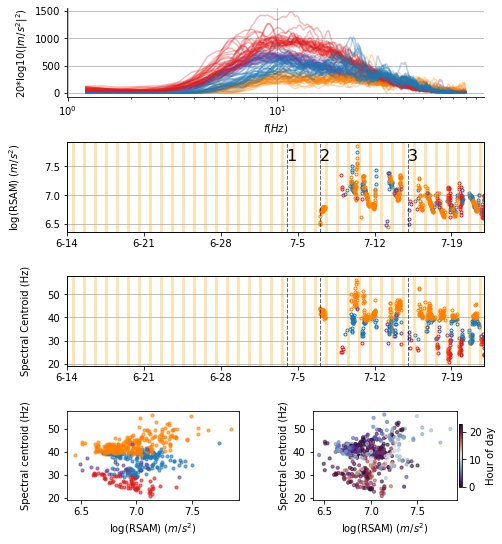

In [139]:
# plt.rcParams.update({'font.size': 8})


## mute depreciation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)

template_index=0


gs = gridspec.GridSpec(8,4)


tfont = 14
lw=.8
alpha=1
alphaT = .6

## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA
## NOISENOISENOISENOISENOISENOISE ###
##SPECTRA##SPECTRA##SPECTRA##SPECTRA##SPECTRA

# ax.axis('off')
ax=plt.subplot(gs[0:2,0:])    


# for k in range(1,KoptN+1):
for k in range(KoptN,0,-1):

# for k in range(KoptN,-1,-1):

    
    catRepK = catRepN[catRepN.Cluster==k]

        

    for i, evID in enumerate(catRepK.event_ID):
        evID = int(evID)
        matSum, specMat = getSpectra(evID,station,path_projN,normed=False)
        ax.plot(fSTFTN,matSum,lw=1.5,c=colors[k-1],alpha=.3)
        plt.grid('on')
        

        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)        
    ax.spines['bottom'].set_visible(True)

    ax.set_ylabel("20*log10(|$m/s^2$|$^2$)")
    ax.set_xlabel('$f (Hz)$',labelpad=4)   
    
    plt.xscale('log')


####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### RSAM
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[2:4,0:]);


lw2=1

# for clus in range(KoptN,0,-1):
for clus in range(1,KoptN+1):

    feature = 'log10RSAM'

    size=3
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_late[df_statN_late.Cluster==clus]
    ax.plot(dff[feature],
          linestyle='none',
          marker='o',
          markeredgecolor=cluscolor,
          markerfacecolor='none',
          markeredgewidth=1,            
          alpha=1,
          ms=size)
    
lc = 'k'
ff=16
yy=7.6
ax.axvline(supraDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.axvline(subDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.axvline(drainEndt,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax.text(supraDraint,yy,'1',fontsize=ff)
ax.text(subDraint,yy,'2',fontsize=ff)
ax.text(drainEndt,yy,'3',fontsize=ff)
ax.set_ylabel('log(RSAM) ($m/s^2$)', labelpad=21)


ax.yaxis.grid()
for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='orange',linestyle='-',linewidth=3,alpha=0.3)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax=plt.gca()
ax.set_xlim(tstart,tend)
ax.set_xticks(day_ticks)
ax.set_xticklabels(day_labels)

####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### SC
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax2=plt.subplot(gs[4:6,0:]);



# for clus in range(KoptN,0,-1):
for clus in range(1,KoptN+1):


    feature = 'SC'

    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_late[df_statN_late.Cluster==clus]
    ax2.plot(dff[feature],
          linestyle='none',
          marker='o',
          markeredgecolor=cluscolor,
          markerfacecolor='none',
          markeredgewidth=1,
          alpha=1,
          ms=size)
    

# for i in range(0,1):
#     df_roll_list[i].z_roll.plot(color='limegreen',ax=ax3)
#     df_roll_list[i].z_roll.plot(color='limegreen',ax=ax4)
    
lc = 'k'
ax2.axvline(supraDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax2.axvline(subDraint,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)
ax2.axvline(drainEndt,c=lc,linestyle='--',linewidth=lw2, alpha=alphaT)

ax2.yaxis.grid()
for i in range(numDays):
    ax2.axvline(hourMaxTemp[i],c='orange',linestyle='-',linewidth=3,alpha=0.3)

for tick in ax2.get_xticklabels():
    tick.set_rotation(0)

ax2.set_xlim(tstart,tend)
ax2.set_xticks(day_ticks)
ax2.set_xticklabels(day_labels)
#     plt.tight_layout()
# plt.ylim(-1e7,train_set['log10abs_sum'].max())
ax2.set_ylabel('Spectral Centroid (Hz)', labelpad=16)

ax5 = ax.twinx()
ax5.set_yticks([])
ax5.set_yticklabels([])


ax6 = ax2.twinx()
ax6.set_yticks([])
ax6.set_yticklabels([])

# figureFunctions2.plotLake(lake_df,meteor_df.rain,ax=ax5,**plt_kwargs)
# figureFunctions2.plotLake(lake_df,meteor_df.rain,ax=ax6,**plt_kwargs)


ax2.set_xticks(day_ticks)
ax2.set_xticklabels(day_labels)


####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 1: cluster 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ax=plt.subplot(gs[6:,0:2]);





for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_late[df_statN_late.Cluster==clus]
    ax.scatter(dff[feature1],dff[feature2],color=cluscolor,alpha=.6,s=10)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)', labelpad=16)





####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Hister 2: Time of Day
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 


ax=plt.subplot(gs[6:,2:]);



sm = plt.cm.ScalarMappable(cmap='twilight_shifted',
                       norm=plt.Normalize(vmin=min(df_statN.index.hour),vmax=max(df_statN.index.hour)))
cbar = plt.colorbar(sm,label='Hour of day',orientation='vertical',shrink=.7,pad=.01);

# for clus in range(KoptN,0,-1):
for clus in range(0,KoptN+1):


    feature1 = 'log10RSAM'
    feature2 = 'SC'
    size=20
    

    # print(i)
    cluscolor = colors[clus-1]
    dff = df_statN_late[df_statN_late.Cluster==clus]
    
#     cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))
    
    
    
    ax.scatter(dff[feature1],dff[feature2],c=dff.index.hour,alpha=.6,s=10,cmap=cm.twilight_shifted)


ax.set_xlabel('log(RSAM) ($m/s^2$)')
ax.set_ylabel('Spectral centroid (Hz)')






####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### #######  
### Labels, etc
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 
####### ####### ####### ####### ####### ####### ####### 

ttt = 15
sss = 30

# ax.text(-25,-150,'a.',color='k',fontsize=sss)
# ax.text(-25,-4,'b.',color='k',fontsize=sss)
# ax.text(120,-4,'c.',color='k',fontsize=sss)


gs.update(wspace=1.5,hspace=2)
    

plt.savefig(pathFig+ f'07_NoiseResults_v3.png', dpi=300)

In [140]:
pathFig

'../05_reports/figures/'

# Figure 11 -- Top Rep FPS and Key States

In [214]:
# ## get highest state transition in top fingerprint

catRep1 = getTopFCat(cat00,1,0)
catRep1N = getTopFCat(cat00N,1,0)

catRep1['event_ID'] = [int(evv) for evv in catRep1.event_ID]
catRep1N['event_ID'] = [int(evv) for evv in catRep1N.event_ID]

#why two the same?? not sure : / 
catRep1['evID'] = [int(evv) for evv in catRep1.evID]



In [215]:


### get select states from top fingerprint in each cluster
sel_state = []
sel_stateN = []

for i, evID in enumerate(catRep1.event_ID):

    fp = getFP(evID,path_proj,outfile_name)

    iMax,jMax = getMaxIndexFP(fp)


    argMaxFP = (iMax,jMax)

    sel_state.append(argMaxFP)

for i, evID in enumerate(catRep1N.event_ID):

    fp = getFP(evID,path_projN,outfile_nameN)

    iMax,jMax = getMaxIndexFP(fp)


    argMaxFP = (iMax,jMax)

    sel_stateN.append(argMaxFP)
    

    
###
print('\n These are the selected state transitions :\n')# (same as their row or column index): \n')
print('IQ: ', sel_state)
print('NS: ', sel_stateN)


#### convert sel_state variable from tuple to single -- this works because key_states are on the diagonal of fingerprint of rep event

sel_state_single = [tup[0] for tup in sel_state if tup[0]==tup[1]]
sel_state_singleN = [tup[0] for tup in sel_stateN if tup[0]==tup[1]]
print('\n These are the key states :\n')# (same as their row or column index): \n')
print('IQ: ', sel_state_single)
print('NS: ', sel_state_singleN)




 These are the selected state transitions :

IQ:  [(12, 12), (14, 14), (13, 13)]
NS:  [(4, 4), (3, 3), (2, 2), (1, 1)]

 These are the key states :

IQ:  [12, 14, 13]
NS:  [4, 3, 2, 1]


## plot colorbar


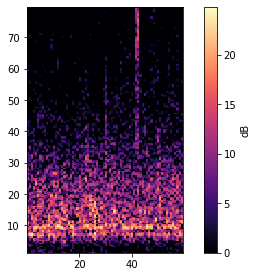

In [216]:
plt.figure(figsize=(width1,height1))

specMat,x = getSgram(path_projN,evID,station)
plt.pcolormesh(tSTFTN, fSTFTN, specMat,cmap=cm.magma, shading='auto')
plt.colorbar(pad=.1, shrink=1,label='dB')

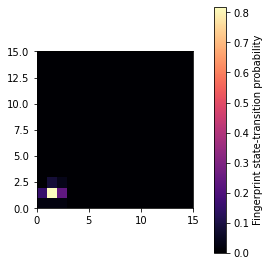

In [217]:


plt.rcParams.update({'font.size': 10})


plt.figure(figsize=(width1,height1))

gs = gridspec.GridSpec(10,10)

ax=plt.subplot(gs[:])

plt.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')
plt.colorbar(pad=.1, shrink=1,label='Fingerprint state-transition probability')



ax.set_aspect('equal')
plt.savefig(pathFig + f'FP_colorbar.png',bbox_inches='tight', dpi=300)

## 

# Represtentative sgrams and fprints
# Represtentative sgrams and fprints
# Represtentative sgrams and fprints

In [218]:
# ## top 5 


#event IDs need to be strings  for FP plotting ... 

catRep5 = getTopFCat(cat00,5,0)
catRep5N = getTopFCat(cat00N,5,0)

catRep5['event_ID'] = [str(int(evv)) for evv in catRep5.event_ID]
catRep5N['event_ID'] = [str(int(evv)) for evv in catRep5N.event_ID]

#why two the same?? not sure : / 
catRep5['evID'] = [str(int(evv)) for evv in catRep5.evID]



In [219]:
catRep.event_ID.iloc[0],catRep5['event_ID'].iloc[0]

(70711162206, '70711160707')

## these are the spec mats -- the input data exactly for SpecUFEx -- normed by mean and non-negged

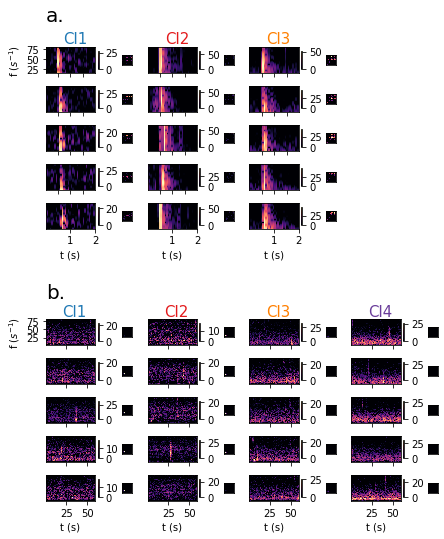

In [299]:
plt.rcParams.update({'font.size': 10})


plt.figure(figsize=(width2,height2))

nRows= 13
nCols= 17

ttt = 15
sss = 30


# fig, axes = plt.subplots(nRows,nCols)

gs = gridspec.GridSpec(nRows,nCols)



    
tfont = 14

labelss = ['Cl1','Cl2','Cl3','Cl4']        



######SGRAM   ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES

for k in range(1,Kopt+1):


    catRep5k = catRep5.where(catRep5.Cluster==k).dropna()
    
    for i, evID in enumerate(catRep5k.event_ID):


        ax=plt.subplot(gs[i+1,(k-1)*4+1:(k-1)*4+4])


        ##SGram

        specMat,x = getSgram(path_proj,evID,station)
        plt.pcolormesh(tSTFT, fSTFT, specMat,cmap=cm.magma, shading='auto')
        plt.colorbar(pad=pad, shrink=shrink,label='',orientation='vertical')

#         cbar = plt.colorbar(pad=0.2, shrink=.7,orientation='horizontal')
#         cbar.set_label('',labelpad=4,fontsize = 10)
#         plt.clim(0,50)

        if i ==0:
            ax.text(.7,90,labelss[k-1],color=colors[k-1],fontsize=ttt)      



#         ## plot FP
#         ax.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')

        
        
        if i == 4:

            ax.set_xlabel('t (s)')

            ax.set_xticklabels(['1','2'])
            ax.set_xticks([1,2])   
        else:

            ax.set_xticklabels('')        


            
        if k==1 and i == 0:
            
            ax.set_ylabel('f ($s^{-1}$)')#,rotation=90)#,labelpad=18) 
            ax.text(0,145,'a.',color='k',fontsize=20)
            
            
        else:
            ax.set_yticklabels([])
            ax.set_yticklabels('')   
            ax.set_yticks([])     
            
            
        

        
        
        
        
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES

for k in range(1,Kopt+1):


    catRep5k = catRep5.where(catRep5.Cluster==k).dropna()
    
    for i, evID in enumerate(catRep5k.event_ID):


        ax=plt.subplot(gs[i+1,(k-1)*4 +4])


        ax.set_aspect('equal')
        ##plot FP

        fp = getFP(evID,path_proj,outfile_name) 

        #normalize fps by local max
        ##     fp = fp / np.max(fp)

        ## plot FP
        ax.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')
        ax.set_xticklabels([])
        ax.set_xticklabels('')        
        ax.set_xticks([])        
        ax.set_yticklabels([])
        ax.set_yticklabels('')   
        ax.set_yticks([])        
    
        
        
        
######SGRAM   ####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE

for k in range(1,KoptN+1):


    catRep5kN = catRep5N.where(catRep5N.Cluster==k).dropna()
    
    for i, evID in enumerate(catRep5kN.event_ID):


        ax=plt.subplot(gs[i+8,(k-1)*4+1:(k-1)*4+4])


        ##SGram

        specMat,x = getSgram(path_projN,evID,station)
        plt.pcolormesh(tSTFTN, fSTFTN, specMat,cmap=cm.magma, shading='auto')
#         plt.colorbar(pad=0.02, shrink=1,label='dB')
        plt.colorbar(pad=pad, shrink=shrink,label='',orientation='vertical')
        
        if i ==0:
            ax.text(20,90,labelss[k-1],color=colors[k-1],fontsize=ttt) 
            
        if i == 4:

            ax.set_xlabel('t (s)')
         

        else:
            
            ax.set_xticklabels('')        

        if k==1 and i == 0:
            
            ax.set_ylabel('f ($s^{-1}$)')#,rotation=90)#,labelpad=18) 
            ax.text(0,145,'b.',color='k',fontsize=20)

        else:
            ax.set_yticklabels([])
            ax.set_yticklabels('')   
            ax.set_yticks([])        
        

        
        
####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
for k in range(1,KoptN+1):


    catRep5kN = catRep5N.where(catRep5N.Cluster==k).dropna()
    
    for i, evID in enumerate(catRep5kN.event_ID):


        ax=plt.subplot(gs[i+8,(k-1)*4 +4])

        

        ##plot FP

        fp = getFP(evID,path_projN,outfile_nameN) 

        #normalize fps by local max
        ##     fp = fp / np.max(fp)

        ## plot FP
        ax.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')
        ax.set_aspect('equal')

        ax.set_xticklabels([])
        ax.set_xticklabels('')        
        ax.set_xticks([])        
        ax.set_yticklabels([])
        ax.set_yticklabels('')   
        ax.set_yticks([])  
        
        

        

# ax.text(0,140,'Icequakes',color='k',fontsize=25)
# ax.text(0,140,'Noise',color='k',fontsize=25)

# ax.text(-15,-110,'a.',color='k',fontsize=sss)
# ax.text(80,-110,'b.',color='k',fontsize=sss)
# ax.text(-15,-4,'c.',color='k',fontsize=sss)
# ax.text(80,-4,'d.',color='k',fontsize=sss)

gs.update(hspace=.5,wspace=1.5)

plt.savefig(pathFig + "repFPSgram.png", dpi=300,bbox_inches='tight')



# Represtentative sgrams NOOO fprints


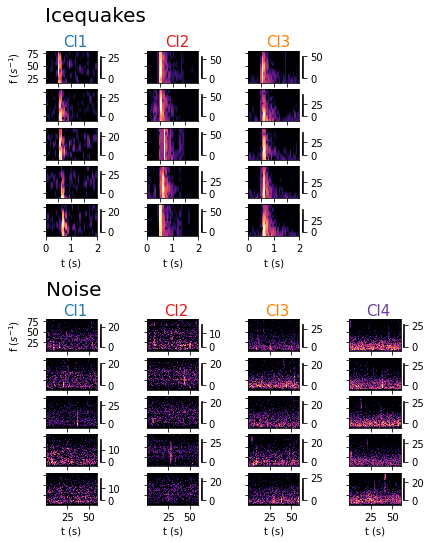

In [300]:
plt.rcParams.update({'font.size': 10})


plt.figure(figsize=(width2,height2))

nRows= 13
nCols= 17

ttt = 15
sss = 30


# fig, axes = plt.subplots(nRows,nCols)

gs = gridspec.GridSpec(nRows,nCols)



    
tfont = 14

labelss = ['Cl1','Cl2','Cl3','Cl4']        



######SGRAM   ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES

for k in range(1,Kopt+1):


    catRep5k = catRep5.where(catRep5.Cluster==k).dropna()
    
    for i, evID in enumerate(catRep5k.event_ID):


        ax=plt.subplot(gs[i+1,(k-1)*4+1:(k-1)*4+4])


        ##SGram
        
        pad = .04
        shrink = .7
        
        
        specMat,x = getSgram(path_proj,evID,station)
        plt.pcolormesh(tSTFT, fSTFT, specMat,cmap=cm.magma, shading='auto')
        plt.colorbar(pad=pad, shrink=shrink,label='')


        if i ==0:
            ax.text(.7,90,labelss[k-1],color=colors[k-1],fontsize=ttt)      



#         ## plot FP
#         ax.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')

        
        
        if i == 4:

            ax.set_xlabel('t (s)')
            ax.set_xticklabels(['0','1','2'])   
            ax.set_xticks([0,1,2])               

        else:

            ax.set_xticklabels('')        


            
        if k==1 and i == 0:
            
            ax.set_ylabel('f ($s^{-1}$)')#,rotation=90)#,labelpad=18) 
            ax.text(0,140,'Icequakes',color='k',fontsize=20)
            
            
        else:
            ax.set_yticklabels([])
            ax.set_yticklabels('')   
#             ax.set_yticks([])     
            
            
        

    
        
        
        
######SGRAM   ####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE

for k in range(1,KoptN+1):


    catRep5kN = catRep5N.where(catRep5N.Cluster==k).dropna()
    
    for i, evID in enumerate(catRep5kN.event_ID):


        ax=plt.subplot(gs[i+8,(k-1)*4+1:(k-1)*4+4])


        ##SGram

        specMat,x = getSgram(path_projN,evID,station)
        plt.pcolormesh(tSTFTN, fSTFTN, specMat,cmap=cm.magma, shading='auto')
        plt.colorbar(pad=pad, shrink=shrink,label='')
        
        if i ==0:
            ax.text(20,90,labelss[k-1],color=colors[k-1],fontsize=ttt) 
            
        if i == 4:

            ax.set_xlabel('t (s)')


        else:

            ax.set_xticklabels('')        

        if k==1 and i == 0:
            
            ax.set_ylabel('f ($s^{-1}$)')#,rotation=90)#,labelpad=18) 
            ax.text(0,140,'Noise',color='k',fontsize=20)

        else:
            ax.set_yticklabels([])
            ax.set_yticklabels('')   
#             ax.set_yticks([])        
        


# ax.text(0,140,'Icequakes',color='k',fontsize=25)
# ax.text(0,140,'Noise',color='k',fontsize=25)

# ax.text(-15,-110,'a.',color='k',fontsize=sss)
# ax.text(80,-110,'b.',color='k',fontsize=sss)
# ax.text(-15,-4,'c.',color='k',fontsize=sss)
# ax.text(80,-4,'d.',color='k',fontsize=sss)

gs.update(wspace=1)

plt.savefig(pathFig + "repFPSgram_noFP.png", dpi=300,bbox_inches='tight')



In [301]:
nRows,nCols

(13, 17)

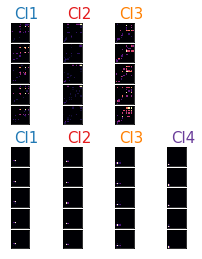

In [302]:
plt.rcParams.update({'font.size': 10})


plt.figure(figsize=(width1,height1))

nRows= 13
nCols= 17

ttt = 15
sss = 30


# fig, axes = plt.subplots(nRows,nCols)

gs = gridspec.GridSpec(12,4)



    
tfont = 14

labelss = ['Cl1','Cl2','Cl3','Cl4']        


        
        
        
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES
######ICEQUAKES######ICEQUAKES######ICEQUAKES######ICEQUAKES

for k in range(1,Kopt+1):


    catRep5k = catRep5.where(catRep5.Cluster==k).dropna()
    
    for i, evID in enumerate(catRep5k.event_ID):


        ax=plt.subplot(gs[i+1,k-1])

        #         ax=plt.subplot(gs[i+1,(k-1)*4+1:(k-1)*4+4])
        if i ==0:
            ax.text(3,18,labelss[k-1],color=colors[k-1],fontsize=ttt)   
        ax.set_aspect('equal')
        ##plot FP

        fp = getFP(evID,path_proj,outfile_name) 

        #normalize fps by local max
        ##     fp = fp / np.max(fp)

        ## plot FP
        ax.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')
        ax.set_xticklabels([])
        ax.set_xticklabels('')        
        ax.set_xticks([])        
        ax.set_yticklabels([])
        ax.set_yticklabels('')   
        ax.set_yticks([])        
    
        
        

        
        
####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
#####NOISE######NOISE######NOISE
for k in range(1,KoptN+1):


    catRep5kN = catRep5N.where(catRep5N.Cluster==k).dropna()
    
    for i, evID in enumerate(catRep5kN.event_ID):

        ax=plt.subplot(gs[i+7,(k-1)])

        if i ==0:
            ax.text(3,18,labelss[k-1],color=colors[k-1],fontsize=ttt)   

        ##plot FP

        fp = getFP(evID,path_projN,outfile_nameN) 

        #normalize fps by local max
        ##     fp = fp / np.max(fp)

        ## plot FP
        plt.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')
        ax.set_aspect('equal')
#         plt.colorbar(pad=pad, shrink=shrink,label='Number of transitions')
        ax.set_xticklabels([])
        ax.set_xticklabels('')        
        ax.set_xticks([])        
        ax.set_yticklabels([])
        ax.set_yticklabels('')   
        ax.set_yticks([])  
        
        

        



gs.update(hspace=0.1,wspace=0)

plt.savefig(pathFig + "repFP.png", dpi=300,bbox_inches='tight')



In [303]:
i


4

# Figure 12 - Reconstructed spectra

## Find scaling factors

In [222]:
k=1
peak_rec_state, peak_spec, scale = CalcDiffPeak(path_proj,cat00,k,RMM,sel_state_single,station)
kN=2
peak_rec_stateN, peak_specN, scaleN = CalcDiffPeak(path_projN,cat00N,kN,RMMN,sel_state_singleN,station)


In [223]:
len(tSTFT),len(tSTFTN)

(33, 72)

## reconstructed spectra with median 

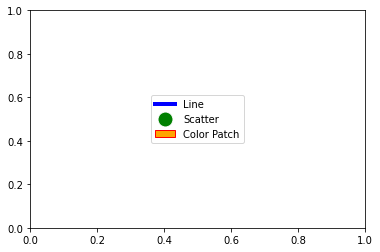

In [224]:
##CUSTOM LEGEND
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r',
                         label='Color Patch')]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')

plt.show()

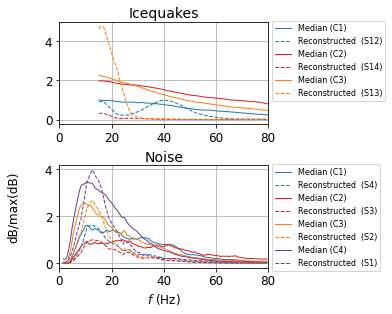

In [225]:
plt.rcParams.update({'font.size': 12})

fig,axes = plt.subplots(figsize = (width1,height1))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(2,1)
gs.update(wspace=.4, hspace=.4)
leg = legN = ['','','','','','','','','','','']

title='Icequakes'
titleN='Noise'

tpad=4


### ### ### ### ### ### ### ### ### ### ### ### 
## NOISE
ax = plt.subplot(gs[0])
ax.set_xlim(0,80)

ax.set_title(title,fontsize=tfont,pad=tpad)
  


lw=.5
alpha=.3






figureFunctions2.plotMedianSpectra(path_proj,cat00,Kopt,fSTFT,station,leg,normed='median',ax=ax,scale=peak_spec,**plt_kwargs)

figureFunctions2.plotReconstructedStates(RMM,
                                         sel_state_single,
                                         fSTFT,
                                         lw=1,
                                         legend='outside',
                                         bb1=1.25,
                                         bb2=.75,                                         
                                         freq_list=None,
                                         normed='median',
                                         ax=ax,
                                         scale=peak_rec_state,
                                         **plt_kwargs)



    
    

ax.set_ylabel('')
ax.set_xlabel('')



# plt.yscale('log')
# plt.xscale('log')





### ### ### ### ### ### ### ### ### ### ### ### 
## NOISE
axN = plt.subplot(gs[1])
axN.set_xlim(0,80)

axN.set_title(titleN,fontsize=tfont,pad=tpad)
  




figureFunctions2.plotMedianSpectra(path_projN,
                                   cat00N,
                                   KoptN,
                                   fSTFTN,
                                   station,
                                   leg,
                                   normed='median',
                                   ax=axN,
                                   scale=peak_specN,
                                   **plt_kwargs)



figureFunctions2.plotReconstructedStates(RMMN,
                                         sel_state_singleN,
                                         fSTFTN,
                                         lw=1,
                                         legend='outside',
                                         bb1=1.25,
                                         bb2=.75,                                         
                                         freq_list=None,
                                         normed='median',
                                         ax=axN,
                                         scale=peak_rec_stateN,
                                         **plt_kwargs)

    
    

axN.set_ylabel('')
axN.set_xlabel('$f$ (Hz)')



# plt.yscale('log')
# plt.xscale('log')




### format legend


legend_elements = []
lww = 1

for k in range(1,Kopt+1):
    legend_elements.append(Line2D([0], [0], color=colors[k-1], lw=lww, label=f'Median (C{k})'))
    legend_elements.append(Line2D([0], [0], color=colors[k-1], lw=lww, linestyle='--', label=f'Reconstructed  (S{sel_state_single[k-1]})'))    
                   
legend_elementsN = []

for k in range(1,KoptN+1):
    legend_elementsN.append(Line2D([0], [0], color=colors[k-1], lw=lww, label=f'Median (C{k})'))
    legend_elementsN.append(Line2D([0], [0], color=colors[k-1], lw=lww, linestyle='--', label=f'Reconstructed  (S{sel_state_singleN[k-1]})'))    
                   
                 
axN.text(-20,.999,'dB/max(dB)',rotation=90)

fsl=8
ax.legend(handles=legend_elements,bbox_to_anchor=(1,1.05),fontsize=fsl)
axN.legend(handles=legend_elementsN,bbox_to_anchor=(1,1.05),fontsize=fsl)





plt.savefig(pathFig + f'14_reveng.png',bbox_inches='tight', dpi=300)

In [226]:
def plotReconstructedStates2(RMM,sel_state_single,fSTFT,lw=1,freq_list=None,colorBy='cluster',legend='inside',bb1=1,bb2=0,ax=None,normed='None',scale=1, **plt_kwargs):

    if ax is None:
        ax = plt.gca()

    colors      =     plt_kwargs['colors']


    for i, st in enumerate(sel_state_single):


        if colorBy=='all':
            cc = 'k'
        else:
            cc = colors[i]


        reconst_state = RMM[:,st]

        if normed=='max':
            reconst_state = reconst_state / np.max(reconst_state)

        if normed=='None':
            reconst_state = reconst_state ## because it's based on spectra that were normed by their medians .....


        reconst_state = reconst_state / scale

        ax.plot(fSTFT,reconst_state,
                lw=lw,
                ls='--',
                color=cc,
               label=f"S{sel_state_single[i]}")    #     /RMM[:,st].max()



    if legend=='inside':
        ax.legend()
    if legend=='outside':
        ax.legend(loc='right',bbox_to_anchor=(bb1,bb2))

    ax.set_xlabel('$f$ (Hz)',labelpad=4)
    ax.set_ylabel('Reconstructed dB')
    plt.grid('on')

# .oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo..oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo.oOo

def plotMedianSpectra2(path_proj,cat00,Kopt,fSTFT,station,leg,lw=1,normed='median',scale=1,ax=None,**plt_kwargs):

    if ax is None:
        ax = plt.gca()

    colors      =     plt_kwargs['colors']


    for k in range(1,Kopt+1):

        if normed=='median':
            specMatsum_med=getSpectraMedian(path_proj,cat00,k,station,normed=True)

            specMatsum_med = specMatsum_med / scale

            ylabell = 'dB/median(dB)'
        elif normed=='max':
            specMatsum_med=getSpectraMedian(path_proj,cat00,k,station,normed=False)
            specMatsum_med = specMatsum_med / np.max(specMatsum_med)
            ylabell = 'Normalized dB'
        else:
            specMatsum_med=getSpectraMedian(path_proj,cat00,k,station,normed=False)


        ax.plot(fSTFT,specMatsum_med,
                 lw=lw,
                 color=colors[k-1],
                 alpha=1,
                 label=leg[k-1]);

    ax.grid('on')
    ax.set_xlabel('$f$ (Hz)',labelpad=4)
    ax.set_ylabel(ylabell)

In [227]:
# def CalcDiffPeak_Cluster(catRep,k,RMM,sel_state,station,path_proj):
#     """
#     For cluster k, divide max of Rep spectra by median of maxes of top representative spectra
#     """
    
    
#     maxAmp_list = []
    
    
#     # for Rep catalog of cluster k, get list of maxes of spectra
#     catRepK = catRep[catRep.Cluster==k]
#     for i, evID in enumerate(catRepK.event_ID):      
#         spectra, __ = getSpectra(evID,station,path_proj,normed=True)
#         maxAmp_list.append(np.max(spectra))
            
#     maxAmp_list_array = np.array(maxAmp_list)
    
#     medianMaxAmp = np.median(maxAmp_list_array)
                    
#     ## get max value of reconstructed spectra from selected stated
#     rec_state = RMM[:,sel_state[k-1]]
#     maxRecSpec = np.max(rec_state) 



#     scale = maxRecSpec / medianMaxAmp

#     return scale

# k=1
# scale = CalcDiffPeak_Cluster(catRep,k,RMM,sel_state,station,path_proj)
# scale

## Print more fingerprints for Kmeans in workflow

In [228]:

#### No need to run again .... 

# Nsamp=100

# plt.figure(figsize=(width1,height2*Nsamp/5))


# # fig, axes = plt.subplots(nRows,nCols)

# gs = gridspec.GridSpec(Nsamp,1)

# gs.update(wspace=0, hspace=0.2)

    
# tfont = 14
# symbolSize = 150    
# shift = .4 #shift marker for selected states 



# indRand = np.random.randint(0,len(cat00),Nsamp)

# for i, ind in enumerate(indRand):


#     ax=plt.subplot(gs[i,0])
#     ax.set_aspect('equal')
        
#     evID = cat00.event_ID.iloc[ind]
#     clus = cat00.Cluster.iloc[ind]
        
#     #normalize fps by local max
#     fp = getFP(evID,path_proj,outfile_name) 
#     fp = fp / np.max(fp)
        

#     # plot FP
#     plt.pcolormesh(fp,cmap=cm.magma)#, aspect='auto')

    
# #     ticks
# #     plt.yticks(ticks = [0,5,10],labels=['0','5','10'])
# #     plt.xticks(ticks = [0,5,10],labels=['0','5','10'])

# #     plt.yticks(ticks = [],labels=[''])
# #     plt.xticks(ticks = [],labels=[''])

#     ax.set_xlabel('')
#     ax.set_xticks([])

#     ax.set_xticklabels('')
#     ax.set_ylabel(f'{clus}')
#     ax.set_yticklabels('')    
#     ax.set_yticks([])        
        
    

    
    
# plt.savefig(pathFig + f'fingerprints_Kmeans.png',bbox_inches='tight', dpi=300)


## Simplified Rev Eng Figure

In [229]:
sel_state_single[0]

12

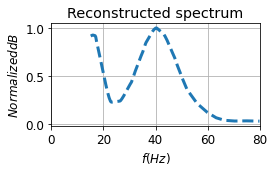

In [230]:
plt.rcParams.update({'font.size': 12})

fig,axes = plt.subplots(figsize = (width1,height1))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(2,1)
gs.update(wspace=.4, hspace=.4)
leg = legN = ['','','','','','','','','','','']

title='Icequakes'
titleN='Noise'

tpad=4


### ### ### ### ### ### ### ### ### ### ### ### 
## NOISE
ax = plt.subplot(gs[0])
ax.set_xlim(0,80)

# ax.set_title(title,fontsize=tfont,pad=tpad)
  


lw=.5
alpha=.3




lww = 3

# figureFunctions2.plotMedianSpectra(path_proj,cat00,1,fSTFT,station,leg,normed='median',lw=3,ax=ax,scale=peak_spec,**plt_kwargs)

# ax.plot(RMM[0] / np.max(RMM[0]))

figureFunctions2.plotReconstructedStates(RMM,
                                         [sel_state_single[0]],
                                         fSTFT,
                                         lw=lww,
                                         legend='outside',
                                         bb1=1.25,
                                         bb2=.75,                                         
                                         freq_list=None,
                                         normed='median',
                                         ax=ax,
                                         scale=peak_rec_state,
                                         **plt_kwargs)



    
    

ax.set_ylabel('')
ax.set_xlabel('')

plt.legend([])

plt.title('Reconstructed spectrum')

# plt.yscale('log')
# plt.xscale('log')




### format legend


# legend_elements = []


# for k in [1]:
#     legend_elements.append(Line2D([0], [0], color=colors[k-1], lw=lww, label=f'Median (Cluster {k})'))
#     legend_elements.append(Line2D([0], [0], color=colors[k-1], lw=lww, linestyle='--', label=f'Reconstructed Sp (State {sel_state_single[k-1]})'))    
                   


fsl=13
# ax.legend(handles=legend_elements,bbox_to_anchor=(.7,1.05),fontsize=fsl)


plt.xlabel('$f (Hz)$')
plt.ylabel('$Normalized dB$')
# ax.set_ylim(0,.25)
ax.get_legend().remove()

plt.savefig(pathFig + f'15_reveng_WF.png',bbox_inches='tight', dpi=300)